<h1> Modelos Computacionales I.
<h2> Unidad de probabilidad y estadística. 
<h3> Práctica 2. Carolina Bernal Rodríguez.

Los archivos con datos de la tarea de detección:“Det”. En esta tarea había
seis condiciones experimentales, cada una corresponde a un valor distinto de amplitud de
estimulación: 0μm (no hay estímulo), 6μm, 8μm, 10μm, 12μm y 24μm. Similar a los de
discariminación, estos archivos están divididos en bloques separados por un salto de línea.
Los bloques van de de menor a mayor: el primer bloque es de la condición con 0μm y
el último es con 24μm. El número de ensayos en cada archivo no es necesariamente el mismo.

<h2> Ejercicio 1. </h2>


1. Transformada z (z-scores), y vamos a usar los siguientes archivos: de la tarea de discriminación de patrones ```TiemposNeuDPC1.csv```, ```TiemposNeuDPC2.csv``` y ```TiemposNeuS1.csv```; de la tarea de detección ```DetNeuS1_B``` y ```NeuDetS1_D```. Antes de empezar, calcule las tasas de disparo de las cinco neuronas: para las tres neuronas de S1 emplee ventanas de 50ms y pasos de 10 ms; para las dos de DPC, ventanas de 200ms y pasos de 40ms. Vamos a calcular la evolución temporal para diferentes z-scores promedio por clase y neurona. Para todos los incisos, grafique cada una de sus curvas con una barra de error que indique ± una desviación estándar del correspondiente z-score.

(a) Obten y grafica el z-score (para cada neurona y clase) usando la tasa de todas
las ventanas de tiempo (t ∈ [−2, 8] en la tarea de patrones y t ∈ [−2, 3,5] para
detección) y ensayos para calcular el valor medio y la desviación estándar con las
que se computa la transformada z en cada clase.

In [1]:
#Importamos las librerías. 
import pandas as pd
import csv
import numpy as np 
from matplotlib import pyplot as plt 
from matplotlib import style
from io import StringIO
import seaborn as sns
# Ajuste de distribuciones
# ==============================================================================
from scipy import stats
import inspect
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.optimize import curve_fit
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import poisson
from scipy.stats import powerlaw
import math 
# Librería creada para el cálculo de tasa disparo de archivos Tiempos
# ==============================================================================
import Carolina_tasa_tiempos as Ctiempos
import Carolina_lectura_det as Cdet

In [2]:
#Ajustes para la estética de las gráficas 
plt.rcParams['savefig.bbox'] = "tight"
style.use('seaborn-whitegrid') or plt.style.use('seaborn-whitegrid')

In [3]:
#Ajustes para la estética de las gráficas
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})

De la práctica anterior sabemos cómo trabajar los archivos de Tiempos para calcular la tasa de disparo, de ellos sabemos que fueron realizados 15 ensayos en cada una de las 4 clases, i.e. 60 ensayos en total.

In [4]:
#Leemos los archivos csv. 
tiempos_neudpc_1 = pd.read_csv('Practica1_Estadistica/TiemposNeuDPC1.csv',header=None, sep='\n')
tiempos_neudpc_2 = pd.read_csv('Practica1_Estadistica/TiemposNeuDPC2.csv',header=None, sep='\n')
tiempos_neus1    = pd.read_csv('Practica1_Estadistica/TiemposNeuS1.csv',header=None, sep='\n')

In [5]:
#Función de la que se obtiene los extremos de la lista de intervalos 
def lista_extremos(lim_inferior,lim_superior,paso_tiempo):
    lista_extremos_final = []
    rango = (abs(lim_inferior)+abs(lim_superior))/paso_tiempo
    for i in range(int(rango)): 
        lista_extremos_final.append(lista_tiempos[i][1])
    return lista_extremos_final

In [6]:
#Función que calcula la tasa de disparo agrupadas, así como el número de espigas por clase y evento 
def tasa_disparo_clases_agrupadas(data,ext_inf,ext_sup,ancho_vent,paso_temp):
    ensayos = 15
    listas_de_clase = []
    array_lista_suma = [] 
    array_tasa_disparo = []
    array_tren_espigas = []
    array_df_tasa_disparo = []
    
    clases_mod = Ctiempos.separar_por_clase(data)
    
    #lista_extremos_final = lista_extremos(ext_inf,ext_sup,paso_temp)
    
    for i in range(len(clases_mod)):
        lista_de_listas = Ctiempos.numero_espigas_lista_de_listas(clases_mod[i],lista_tiempos)
        listas_de_clase.append(lista_de_listas)
        
        lista_de_listas_m = listas_de_clase[i]
        lista_suma = Ctiempos.acumulado_espigas(lista_de_listas_m)
        array_lista_suma.append(lista_suma)
        
        tasa_disparo = list(map(lambda x: x/((ancho_vent)*(ensayos)), array_lista_suma[i]))
        array_tasa_disparo.append(tasa_disparo)
        
        tren_de_espigas ={
                        'tiempo': lista_extremos(ext_inf,ext_sup,paso_temp),
                        'tasa_disparo': array_tasa_disparo[i]
                         }
        array_tren_espigas.append(tren_de_espigas)
        df_tasa_disparo = pd.DataFrame(array_tren_espigas[i])
        array_df_tasa_disparo.append(df_tasa_disparo)
        
    return  listas_de_clase,array_df_tasa_disparo

In [7]:
#También podemos definir una función que obtenga la tasa de disparo de todos los tiempos 
def df_todas_tasa_disparo_tiempos(data,lista_tiempos,lista_extremos_final,ancho_vent):
    todas_clases =  data[0:60] 
    todos_tiempos = todas_clases[0].str.split(',', expand=True)
    todos_tiempos.fillna(value=np.nan,inplace=True)
    columnas = todos_tiempos.shape[1]
    
    for col in range(columnas):
        todos_tiempos[col] = todos_tiempos[col].astype(float)
    
    #lista_tiempos = Ctiempos.particiones_temporales([[-2,-1.8]],0.04,-2,8,0.2)
    lista_de_listas = Ctiempos.numero_espigas_lista_de_listas(todos_tiempos,lista_tiempos)
    lista_suma = Ctiempos.acumulado_espigas(lista_de_listas)
    tasa_disparo = list(map(lambda x: x/((ancho_vent)*(60)), lista_suma))

    #lista_extremos_final = lista_extremos(-2,8,0.04)
    #Creamos un diccionario con los tiempos creados por intervalos y la tasa de disparo 
    tren_de_espigas ={
        'tiempo': lista_extremos_final,
        'tasa_disparo': tasa_disparo
    }
    df_tasa_disparo= pd.DataFrame(tren_de_espigas)
    
    return df_tasa_disparo

In [8]:
lista_tiempos = Ctiempos.particiones_temporales([[-2,-1.8]],0.04,-2,8,0.2)
lista_extremos_final = lista_extremos(-2,8,0.04)
df_dpc1 = df_todas_tasa_disparo_tiempos(tiempos_neudpc_1,lista_tiempos,lista_extremos_final,0.2)

In [9]:
# función que calcula el Z score promedio de la tasa de disparo 
def Z_score_tasa(data):
    
    mean_data = np.mean(data.tasa_disparo)
    std_data  = np.std(data.tasa_disparo)
    Z_score   = ( data.tasa_disparo - mean_data ) / std_data
    
    return Z_score

In [10]:
#Función Z-score de un conjunto de datos 
def Z_score(data,mean_data,std_data):
    return (data - mean_data) / std_data

In [11]:
# Esta función se utiliza a la par de df_todas_tasa_disparo_tiempos, calcula los disparos en la lista 
def lista_disparos_completos(data):
    lista_disparos = []
    for i in range(len(data)):
        lista_disparos.append(np.array(data[i].tasa_disparo))
    
    return lista_disparos

In [12]:
lista_tiempos = Ctiempos.particiones_temporales([[-2,-1.8]],0.04,-2,8,0.2)
lista_de_clase_dpc1,array_df_tasa_disparo_dpc1 = tasa_disparo_clases_agrupadas(tiempos_neudpc_1,-2,8,0.2,0.04)

In [13]:
#El total de eventos en los que ocurrió un disparo de neurona o espiga de la lista_de_clase obtenida de la función
# tasa_disparo_clases_agrupadas, cada arreglo de clase cuenta con 15 ensayos 
#En el caso de DPC para la ventana 0.2 a pasos de 0.04 los tiempos son: tiempos= np.arange(-2,8,0.04) son 250 particiones,
# sin embargo, observando la tabla de tasa de disparo notamos que posterior a 246 los valores temporales son >8s.
def Total_eventos_dpc(lista_de_clase,ancho_vent):
    arreglo_clase = np.array(lista_de_clase)
    clase_1  = arreglo_clase[0][:246]
    arreglo_clase1 = clase_1 / ancho_vent
    clase_2  = arreglo_clase[1][:246]
    arreglo_clase2 = clase_2 / ancho_vent
    clase_3  = arreglo_clase[2][:246]
    arreglo_clase3 = clase_3 / ancho_vent
    clase_4  = arreglo_clase[3][:246]
    arreglo_clase4 = clase_4 / ancho_vent
    TotalEventos_dpc=np.vstack([arreglo_clase1,arreglo_clase2,arreglo_clase3,arreglo_clase4])
    return TotalEventos_dpc #contiene cada clase y tiene longitud de los 60 ensayos totales

In [14]:
def Total_eventos_dpc_mod(lista_de_clase,ancho_vent):
    arreglo_clase = np.array(lista_de_clase)
    clase_1  = arreglo_clase[0]
    arreglo_clase1 = clase_1 / ancho_vent
    clase_2  = arreglo_clase[1]
    arreglo_clase2 = clase_2 / ancho_vent
    clase_3  = arreglo_clase[2]
    arreglo_clase3 = clase_3 / ancho_vent
    clase_4  = arreglo_clase[3]
    arreglo_clase4 = clase_4 / ancho_vent
    TotalEventos_dpc=np.vstack([arreglo_clase1,arreglo_clase2,arreglo_clase3,arreglo_clase4])
    return TotalEventos_dpc #contiene cada clase y tiene longitud de los 60 ensayos totales

In [15]:
Total_eventos_dpc(lista_de_clase_dpc1,0.2)[0]

array([45., 50., 45., 55., 60., 55., 45., 50., 45., 40., 50., 55., 55.,
       40., 40., 45., 50., 45., 50., 60., 50., 35., 35., 25., 20., 10.,
       10., 10., 15., 20., 20., 25., 20., 15., 10., 15., 10., 15., 20.,
       20., 20., 35., 40., 35., 35., 35., 25., 15., 30., 30., 35., 40.,
       45., 35., 45., 55., 60., 70., 75., 75., 75., 70., 70., 70., 55.,
       45., 30., 15., 10., 10.,  5.,  5.,  5.,  0.,  5.,  5.,  5.,  5.,
        5.,  0.,  5.,  5.,  5.,  5., 10., 10., 15., 15., 20., 15., 10.,
       10., 10.,  5., 15., 20., 15., 15., 30., 25., 20., 25., 25., 20.,
       25., 25., 20., 30., 20., 10., 10., 10.,  0., 10., 10., 15., 20.,
       20., 20., 30., 35., 35., 40., 30., 25., 15., 15., 10., 15., 15.,
       20., 25., 25., 20., 15., 10.,  5.,  5.,  5.,  5.,  5.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,  5.,
        5.,  5.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [16]:
def graficas_zscore_dpc_todas_ventanas(lista_de_clase,fun,ancho_vent,paso_tiempo,neurona,colores_zs,nombre_graf):

        TotalEventos_dpc = fun(lista_de_clase,ancho_vent)
        clase_1 =  TotalEventos_dpc[0:15]
        clase_2 =  TotalEventos_dpc[15:30]
        clase_3 =  TotalEventos_dpc[30:45]
        clase_4 =  TotalEventos_dpc[45:60]
    
        mean_data = np.mean(TotalEventos_dpc) #µ
        std_data  = np.std(TotalEventos_dpc) #σ 
        
        Z_clase1 = Z_score(clase_1,mean_data,std_data)
        Z_clase2 = Z_score(clase_2,mean_data,std_data)
        Z_clase3 = Z_score(clase_3,mean_data,std_data)
        Z_clase4 = Z_score(clase_4,mean_data,std_data)
    
        ZProm_clase1 = np.mean(Z_clase1,axis=0) 
        Z_mas_1 = ZProm_clase1 + np.std(ZProm_clase1)
        Z_menos_1 = ZProm_clase1 - np.std(ZProm_clase1)
        
        ZProm_clase2 = np.mean(Z_clase2,axis=0) 
        Z_mas_2 = ZProm_clase2 + np.std(ZProm_clase2)
        Z_menos_2 = ZProm_clase2 - np.std(ZProm_clase2)
        
        ZProm_clase3 = np.mean(Z_clase3,axis=0) 
        Z_mas_3 = ZProm_clase3 + np.std(ZProm_clase3)
        Z_menos_3 = ZProm_clase3 - np.std(ZProm_clase3)
        
        ZProm_clase4 = np.mean(Z_clase4,axis=0) 
        Z_mas_4 = ZProm_clase4 + np.std(ZProm_clase4)
        Z_menos_4 = ZProm_clase4 - np.std(ZProm_clase4)
        
        fig=plt.figure(figsize=(19,11)) #ancho,largo
        fig.suptitle(f"Z-score de la {neurona[0]} en {neurona[1]} de discriminación de patrones con una ventana de {ancho_vent}s y pasos de {paso_tiempo}s.",fontsize=20)
        axs=fig.subplots(2,2)
        tiempos_dpc = np.arange(-2,8,paso_tiempo)
        
        axs[0,0].plot(tiempos_dpc,ZProm_clase1,linewidth=3,color=colores_zs[0])
        axs[0,0].fill_between(tiempos_dpc,Z_mas_1,Z_menos_1,color=colores_zs[0],alpha=0.4,label = 'z_score ± σ')
        axs[0,0].set_title("Clase 1",fontsize=15,fontweight="bold")
        axs[0,0].set_xlabel("Tiempo [s]",fontsize=13)
        axs[0,0].set_ylabel("Z-Score",fontsize=13)
        axs[0,0].legend(fontsize=12)
        
        axs[0,1].plot(tiempos_dpc,ZProm_clase2,linewidth=3,color=colores_zs[1])
        axs[0,1].fill_between(tiempos_dpc,Z_mas_2,Z_menos_2,color=colores_zs[1],alpha=0.4,label = 'z_score ± σ')
        axs[0,1].set_title("Clase 2",fontsize=15,fontweight="bold")
        axs[0,1].set_xlabel("Tiempo [s]",fontsize=13)
        axs[0,1].set_ylabel("Z-Score",fontsize=13)
        axs[0,1].legend(fontsize=12)
        
        axs[1,0].plot(tiempos_dpc,ZProm_clase3,linewidth=3,color=colores_zs[2])
        axs[1,0].fill_between(tiempos_dpc,Z_mas_3,Z_menos_3,color=colores_zs[2],alpha=0.4,label = 'z_score ± σ')
        axs[1,0].set_title("Clase 3",fontsize=15,fontweight="bold")
        axs[1,0].set_xlabel("Tiempo [s]",fontsize=13)
        axs[1,0].set_ylabel("Z-Score",fontsize=13)
        axs[1,0].legend(fontsize=12)
        
        axs[1,1].plot(tiempos_dpc,ZProm_clase4,linewidth=3,color=colores_zs[3])
        axs[1,1].fill_between(tiempos_dpc,Z_mas_4,Z_menos_4,color=colores_zs[3],alpha=0.4,label = 'z_score ± σ')
        axs[1,1].set_title("Clase 4",fontsize=15,fontweight="bold")
        axs[1,1].set_xlabel("Tiempo [s]",fontsize=13)
        axs[1,1].set_ylabel("Z-Score",fontsize=13)
        axs[1,1].legend(fontsize=12)
    
        plt.savefig(nombre_graf)
        plt.show()

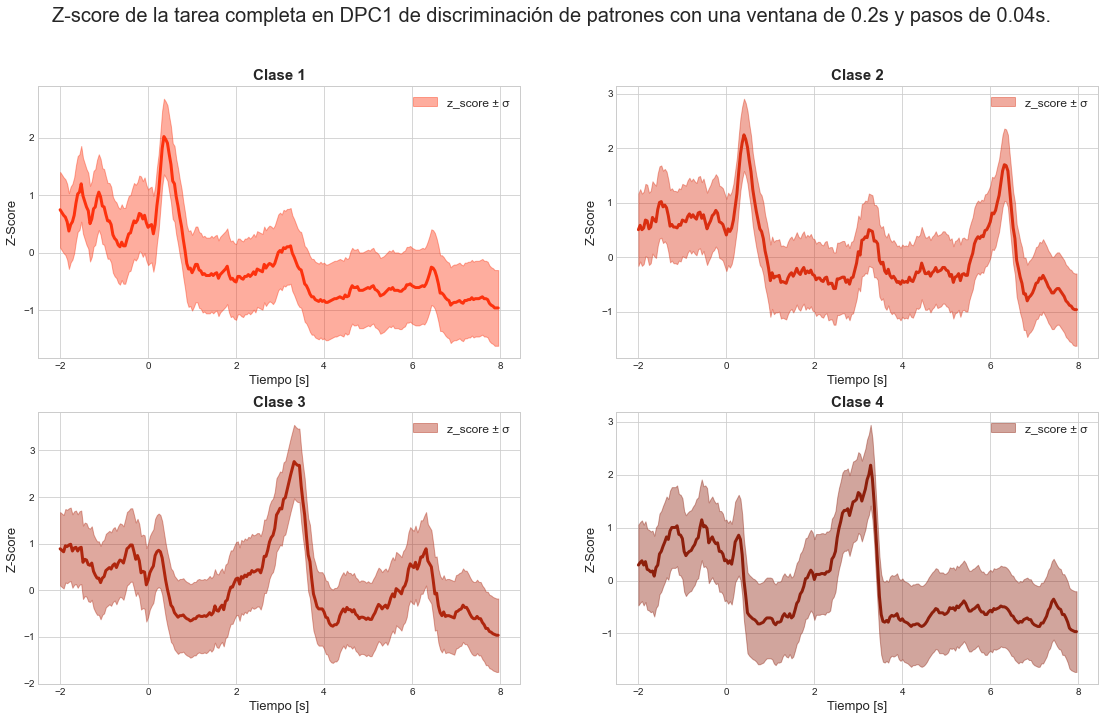

In [17]:
neurona = ['tarea completa', 'DPC1']
colores_zs = ["#fd320e","#da2e10","#af260e","#8d1f0c"]
nombre_graf = 'z_score_completa_dpc1'
ancho_vent = 0.2
paso_tiempo = 0.04
array_clases = array_df_tasa_disparo_dpc1
lista_de_clase = lista_de_clase_dpc1
fun = Total_eventos_dpc
graficas_zscore_dpc_todas_ventanas(lista_de_clase,fun,ancho_vent,paso_tiempo,neurona,colores_zs,nombre_graf)

In [18]:
def transformada_z_1ventana(datos):
    
    
    matriz_zeta=np.zeros_like(datos)
    media=np.mean(datos)
    desviacion=np.std(datos)
    
    for i in range(len(datos)):
        for j in range(len(datos[0])):
            
            zeta=(datos[i][j]-media)/desviacion
            matriz_zeta[i][j]=zeta

            
    return matriz_zeta

In [19]:
lista_tiempos = Ctiempos.particiones_temporales([[-2,-1.8]],0.04,-2,8,0.2)
lista_de_clase_dpc2, array_df_tasa_disparo_dpc2 = tasa_disparo_clases_agrupadas(tiempos_neudpc_2,-2,8,0.2,0.04)

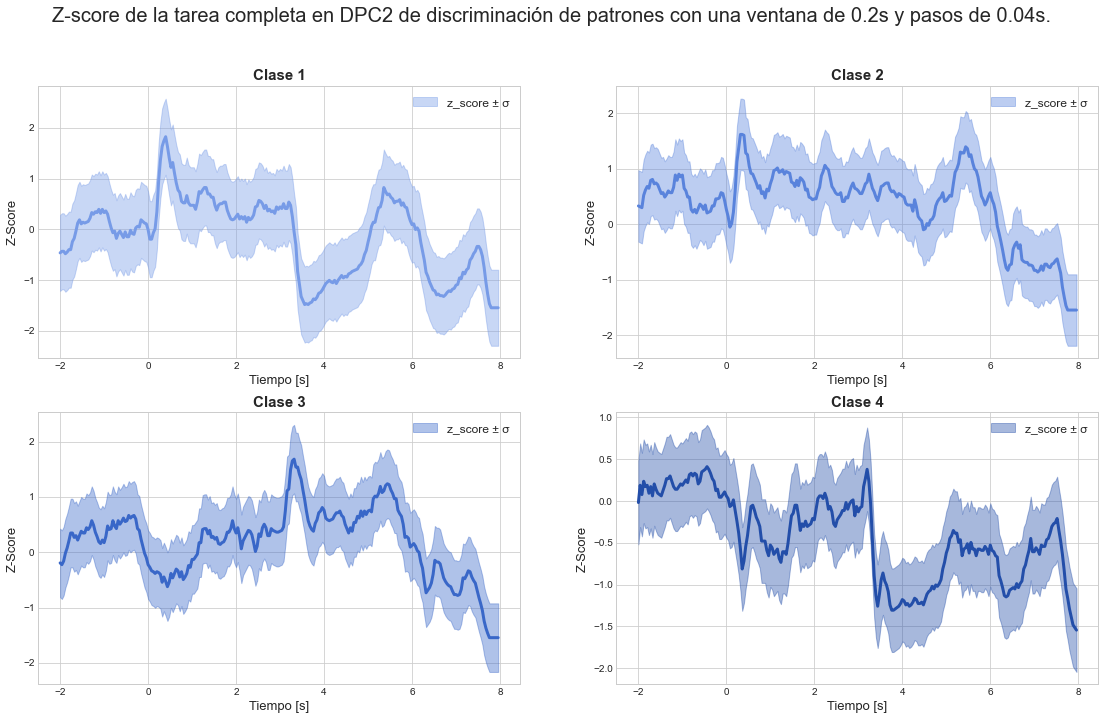

In [20]:
neurona = ['tarea completa','DPC2']
colores_zs = ["#779be7","#5983dc","#3967c8","#234ea9"]
nombre_graf = 'z_score_completa_dpc2'
ancho_vent = 0.2
paso_tiempo = 0.04
array_clases = array_df_tasa_disparo_dpc2
#array_clases = array_df_tasa_disparo_dpc2
fun = Total_eventos_dpc
graficas_zscore_dpc_todas_ventanas(lista_de_clase_dpc2,fun,ancho_vent,paso_tiempo,neurona,colores_zs, nombre_graf)

In [21]:
lista_tiempos = Ctiempos.particiones_temporales([[-2,-1.95]],0.01,-2,8,0.05)
lista_de_clase_s1,array_df_tasa_disparo_s1 = tasa_disparo_clases_agrupadas(tiempos_neus1,-2,8,0.05,0.01)

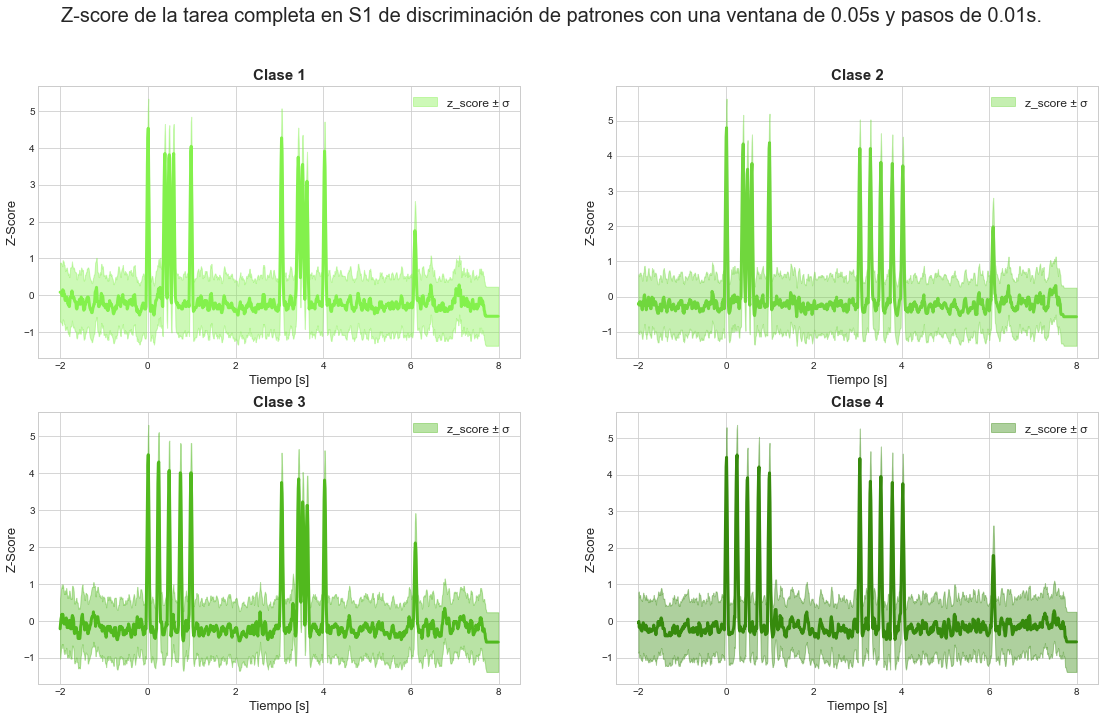

In [22]:
neurona = ['tarea completa','S1']
colores_zs = ["#83f14c","#70d73d","#51b91e","#368a0d"]
nombre_graf = 'z_score_completa_s1'
ancho_vent = 0.05
paso_tiempo = 0.01
array_clases = array_df_tasa_disparo_s1
lista_de_clase = lista_de_clase_s1
fun = Total_eventos_dpc_mod
graficas_zscore_dpc_todas_ventanas(lista_de_clase_s1,fun,ancho_vent,paso_tiempo,neurona,colores_zs,nombre_graf)

Ahora veamos cómo manejar los archivos de detección 'Det'.

In [23]:
#Función que calcula la cantidad de espigas de los archivos de detección 
def espigas_bloques_agrupados(data,ext_inf,ext_sup,ancho_vent,paso_temp):
    #ensayos = 15
    listas_de_bloques = []
    array_lista_suma = [] 
    array_tasa_disparo = []
    array_tren_espigas = []
    array_df_tasa_disparo = []
    
    bloques_mod = Cdet.lectura_archivos_det(data)
    
    for i in range(len(bloques_mod)):
        lista_de_listas = Ctiempos.numero_espigas_lista_de_listas(bloques_mod[i],lista_tiempos)
        listas_de_bloques.append(lista_de_listas)
        
        lista_de_listas_m = listas_de_bloques[i]
        lista_suma = Ctiempos.acumulado_espigas(lista_de_listas_m)
        array_lista_suma.append(lista_suma)
        
    return  listas_de_bloques

In [24]:
lista_tiempos = Ctiempos.particiones_temporales([[-6.5,-6.45]],0.01,-6.5,4.5,0.05)
lista_de_bloques_s1b = espigas_bloques_agrupados('Practica2_Estadistica/Neu_Det_S1B.csv',-6.5,4.5,0.05,0.01)

In [25]:
def total_espigas_bloque(lista_de_bloques,ancho_vent):    
    arreglo_bloques = np.array(lista_de_bloques)
    bloque_1  = arreglo_bloques[0]
    arreglo_bloque1 = np.array(bloque_1) / ancho_vent
    bloque_2  = arreglo_bloques[1]
    arreglo_bloque2 = np.array(bloque_2) / ancho_vent
    bloque_3  = arreglo_bloques[2]
    arreglo_bloque3 = np.array(bloque_3) / ancho_vent
    bloque_4  = arreglo_bloques[3]
    arreglo_bloque4 = np.array(bloque_4) / ancho_vent
    bloque_5  = arreglo_bloques[4]
    arreglo_bloque5 = np.array(bloque_5) / ancho_vent
    bloque_6  = arreglo_bloques[5]
    arreglo_bloque6 = np.array(bloque_6) / ancho_vent
    
    Total_de_espigas=np.vstack([arreglo_bloque1,arreglo_bloque2,arreglo_bloque3,arreglo_bloque4,arreglo_bloque5,arreglo_bloque6])
    return Total_de_espigas

In [26]:
def reducto_bloques(lista_de_bloques_data):
    lista_bloques_agrupados = []
    listas_de_bloques_red = []
    listas_de_bloques_red_1 = []
    listas_de_bloques_red_2 = []
    listas_de_bloques_red_3 = []
    listas_de_bloques_red_4 = []
    listas_de_bloques_red_5 = []

    for i in range(len(lista_de_bloques_data[0])):
        data = lista_de_bloques_data[0][i][450:1000]
        listas_de_bloques_red.append(data)

    for i in range(len(lista_de_bloques_data[1])):
        data_1 = lista_de_bloques_data[1][i][450:1000]
        listas_de_bloques_red_1.append(data_1)    

    for i in range(len(lista_de_bloques_data[2])):
        data_2 = lista_de_bloques_data[2][i][450:1000]
        listas_de_bloques_red_2.append(data_2)     

    for i in range(len(lista_de_bloques_data[3])):
        data_3 = lista_de_bloques_data[3][i][450:1000]
        listas_de_bloques_red_3.append(data_3)  

    for i in range(len(lista_de_bloques_data[4])):
        data_4 = lista_de_bloques_data[4][i][450:1000]
        listas_de_bloques_red_4.append(data_4)    

    for i in range(len(lista_de_bloques_data[5])):
        data_5 = lista_de_bloques_data[5][i][450:1000]
        listas_de_bloques_red_5.append(data_5)    

    lista_bloques_agrupados.append(listas_de_bloques_red)
    lista_bloques_agrupados.append(listas_de_bloques_red_1)
    lista_bloques_agrupados.append(listas_de_bloques_red_2)
    lista_bloques_agrupados.append(listas_de_bloques_red_3)
    lista_bloques_agrupados.append(listas_de_bloques_red_4)
    lista_bloques_agrupados.append(listas_de_bloques_red_5)

    return lista_bloques_agrupados

In [27]:
lista_de_reduc_s1b = reducto_bloques(lista_de_bloques_s1b)

In [28]:
bloque1_s1b  = pd.Series(np.mean(total_espigas_bloque(lista_de_bloques_s1b,0.05)[:50],axis=0))
tiempos = pd.Series(np.arange(-6.5,4.5,0.01))
tren_de_espigas ={
        'tiempo': tiempos,
        'tasa_disparo': bloque1_s1b
    }
df_tasa_disparo= pd.DataFrame(tren_de_espigas)
df_tasa_disparo[450:1000]

<ipython-input-25-7b2f2c65c200>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arreglo_bloques = np.array(lista_de_bloques)


tiempo  tasa_disparo
450   -2.00          28.8
451   -1.99          33.2
452   -1.98          32.4
453   -1.97          32.4
454   -1.96          32.4
..      ...           ...
995    3.45          21.6
996    3.46          20.0
997    3.47          17.2
998    3.48          18.0
999    3.49          16.8

[550 rows x 2 columns]

In [29]:
#total_espigas_bloque(lista_de_reduc_s1a ,0.05)[0]

In [30]:
def graficas_zscore_det_todas_ventanas(nombre_archivo,lista_de_clase,fun,ancho_vent,paso_tiempo,neurona,colores_zs,nombre_graf):
        
        List_archivo = []
        with open(nombre_archivo,'r') as f:
            reader = csv.reader(f,delimiter='\n')
            for i,line in enumerate(reader):
                List_archivo.append(line)
    
        indices_vacios = []
        for i in range(len(List_archivo)):
            if not List_archivo[i]:
                indices_vacios.append(i)
                
        TotalEventos_det = fun(lista_de_clase,ancho_vent)
        bloque1 = TotalEventos_det[:indices_vacios[0]]
        bloque2 = TotalEventos_det[indices_vacios[0]:(indices_vacios[1]-1)]
        bloque3 = TotalEventos_det[(indices_vacios[1]-1):(indices_vacios[2]-2)]
        bloque4 = TotalEventos_det[(indices_vacios[2]-2):(indices_vacios[3]-3)]
        bloque5 = TotalEventos_det[(indices_vacios[3]-3):(indices_vacios[4]-4)]
        bloque6 = TotalEventos_det[(indices_vacios[4]-4):]
        
    
        mean_data = np.mean(TotalEventos_det) #µ
        std_data  = np.std(TotalEventos_det) #σ 
        
        Z_clase1 = Z_score(bloque1,mean_data,std_data)
        Z_clase2 = Z_score(bloque2,mean_data,std_data)
        Z_clase3 = Z_score(bloque3,mean_data,std_data)
        Z_clase4 = Z_score(bloque4,mean_data,std_data)
        Z_clase5 = Z_score(bloque5,mean_data,std_data)
        Z_clase6 = Z_score(bloque6,mean_data,std_data)
    
        ZProm_clase1 = np.mean(Z_clase1,axis=0) 
        Z_mas_1 = ZProm_clase1 + np.std(ZProm_clase1)
        Z_menos_1 = ZProm_clase1 - np.std(ZProm_clase1)
        
        ZProm_clase2 = np.mean(Z_clase2,axis=0) 
        Z_mas_2 = ZProm_clase2 + np.std(ZProm_clase2)
        Z_menos_2 = ZProm_clase2 - np.std(ZProm_clase2)
        
        ZProm_clase3 = np.mean(Z_clase3,axis=0) 
        Z_mas_3 = ZProm_clase3 + np.std(ZProm_clase3)
        Z_menos_3 = ZProm_clase3 - np.std(ZProm_clase3)
        
        ZProm_clase4 = np.mean(Z_clase4,axis=0) 
        Z_mas_4 = ZProm_clase4 + np.std(ZProm_clase4)
        Z_menos_4 = ZProm_clase4 - np.std(ZProm_clase4)
        
        ZProm_clase5 = np.mean(Z_clase5,axis=0) 
        Z_mas_5 = ZProm_clase5 + np.std(ZProm_clase5)
        Z_menos_5 = ZProm_clase5 - np.std(ZProm_clase5)
        
        ZProm_clase6 = np.mean(Z_clase6,axis=0) 
        Z_mas_6 = ZProm_clase6 + np.std(ZProm_clase6)
        Z_menos_6 = ZProm_clase6 - np.std(ZProm_clase6)
        
        fig=plt.figure(figsize=(20,16)) #ancho,largo
        fig.suptitle(f"Z-score de la {neurona[0]} en {neurona[1]} en la tarea de detección con una ventana de {ancho_vent}s y pasos de {paso_tiempo}s.",fontsize=20)
        axs=fig.subplots(3,2)
        tiempos_dpc = np.arange(-2,3.5,paso_tiempo)
       
        axs[0,0].plot(tiempos_dpc,ZProm_clase1,linewidth=3,color=colores_zs[0])
        axs[0,0].fill_between(tiempos_dpc,Z_mas_1,Z_menos_1,color=colores_zs[0],alpha=0.4,label = 'z_score ± σ')
        axs[0,0].set_title("Bloque 1: 0μm",fontsize=15,fontweight="bold")
        axs[0,0].set_xlabel("Tiempo [s]",fontsize=13)
        axs[0,0].set_ylabel("Z-Score",fontsize=13)
        axs[0,0].legend(fontsize=12)
        
        axs[0,1].plot(tiempos_dpc,ZProm_clase2,linewidth=3,color=colores_zs[1])
        axs[0,1].fill_between(tiempos_dpc,Z_mas_2,Z_menos_2,color=colores_zs[1],alpha=0.4,label = 'z_score ± σ')
        axs[0,1].set_title("Bloque 2: 6μm",fontsize=15,fontweight="bold")
        axs[0,1].set_xlabel("Tiempo [s]",fontsize=13)
        axs[0,1].set_ylabel("Z-Score",fontsize=13)
        axs[0,1].legend(fontsize=12)
        
        axs[1,0].plot(tiempos_dpc,ZProm_clase3,linewidth=3,color=colores_zs[2])
        axs[1,0].fill_between(tiempos_dpc,Z_mas_3,Z_menos_3,color=colores_zs[2],alpha=0.4,label = 'z_score ± σ')
        axs[1,0].set_title("Bloque 3: 8μm",fontsize=15,fontweight="bold")
        axs[1,0].set_xlabel("Tiempo [s]",fontsize=13)
        axs[1,0].set_ylabel("Z-Score",fontsize=13)
        axs[1,0].legend(fontsize=12)
        
        axs[1,1].plot(tiempos_dpc,ZProm_clase4,linewidth=3,color=colores_zs[3])
        axs[1,1].fill_between(tiempos_dpc,Z_mas_4,Z_menos_4,color=colores_zs[3],alpha=0.4,label = 'z_score ± σ')
        axs[1,1].set_title("Bloque 4: 10μm",fontsize=15,fontweight="bold")
        axs[1,1].set_xlabel("Tiempo [s]",fontsize=13)
        axs[1,1].set_ylabel("Z-Score",fontsize=13)
        axs[1,1].legend(fontsize=12)
    
        axs[2,0].plot(tiempos_dpc,ZProm_clase5,linewidth=3,color=colores_zs[4])
        axs[2,0].fill_between(tiempos_dpc,Z_mas_5,Z_menos_5,color=colores_zs[4],alpha=0.4,label = 'z_score ± σ')
        axs[2,0].set_title("Bloque 5: 12μm",fontsize=15,fontweight="bold")
        axs[2,0].set_xlabel("Tiempo [s]",fontsize=13)
        axs[2,0].set_ylabel("Z-Score",fontsize=13)
        axs[2,0].legend(fontsize=12)
        
        axs[2,1].plot(tiempos_dpc,ZProm_clase6,linewidth=3,color=colores_zs[5])
        axs[2,1].fill_between(tiempos_dpc,Z_mas_6,Z_menos_6,color=colores_zs[5],alpha=0.4,label = 'z_score ± σ')
        axs[2,1].set_title("Bloque 6: 24μm",fontsize=15,fontweight="bold")
        axs[2,1].set_xlabel("Tiempo [s]",fontsize=13)
        axs[2,1].set_ylabel("Z-Score",fontsize=13)
        axs[2,1].legend(fontsize=12)
    
        plt.savefig(nombre_graf)
        plt.show()

In [31]:
len(np.arange(-2,3.5,0.01))

550

<ipython-input-25-7b2f2c65c200>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arreglo_bloques = np.array(lista_de_bloques)


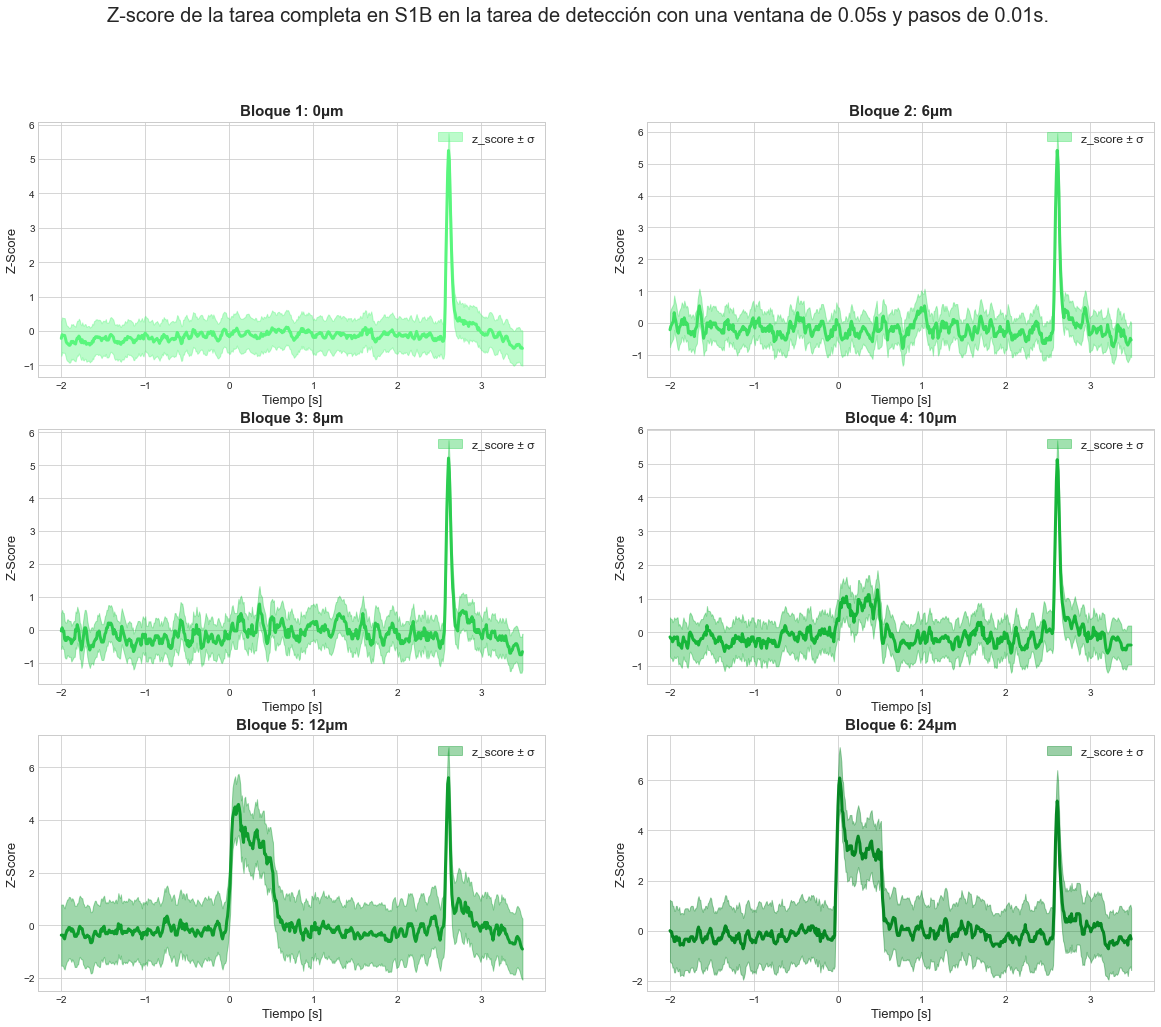

In [32]:
neurona = ['tarea completa','S1B']
colores_zs = ["#59f67d","#3ee063","#2ccd50","#16b639","#0f9d2e","#068723"]
nombre_graf = 'z_score_completa_det_s1b'
ancho_vent = 0.05
paso_tiempo = 0.01
nombre_archivo = 'Practica2_Estadistica/Neu_Det_S1B.csv'
lista_de_clase = lista_de_reduc_s1b
fun = total_espigas_bloque
graficas_zscore_det_todas_ventanas(nombre_archivo,lista_de_clase,fun,ancho_vent,paso_tiempo,neurona,colores_zs,nombre_graf)

In [33]:
lista_tiempos = Ctiempos.particiones_temporales([[-6.5,-6.45]],0.01,-6.5,4.5,0.05)
lista_de_bloques_s1d = espigas_bloques_agrupados('Practica2_Estadistica/Neu_Det_S1D.csv',-6.5,4.5,0.05,0.01)

In [34]:
lista_de_reduc_s1d = reducto_bloques(lista_de_bloques_s1d)

<ipython-input-25-7b2f2c65c200>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arreglo_bloques = np.array(lista_de_bloques)


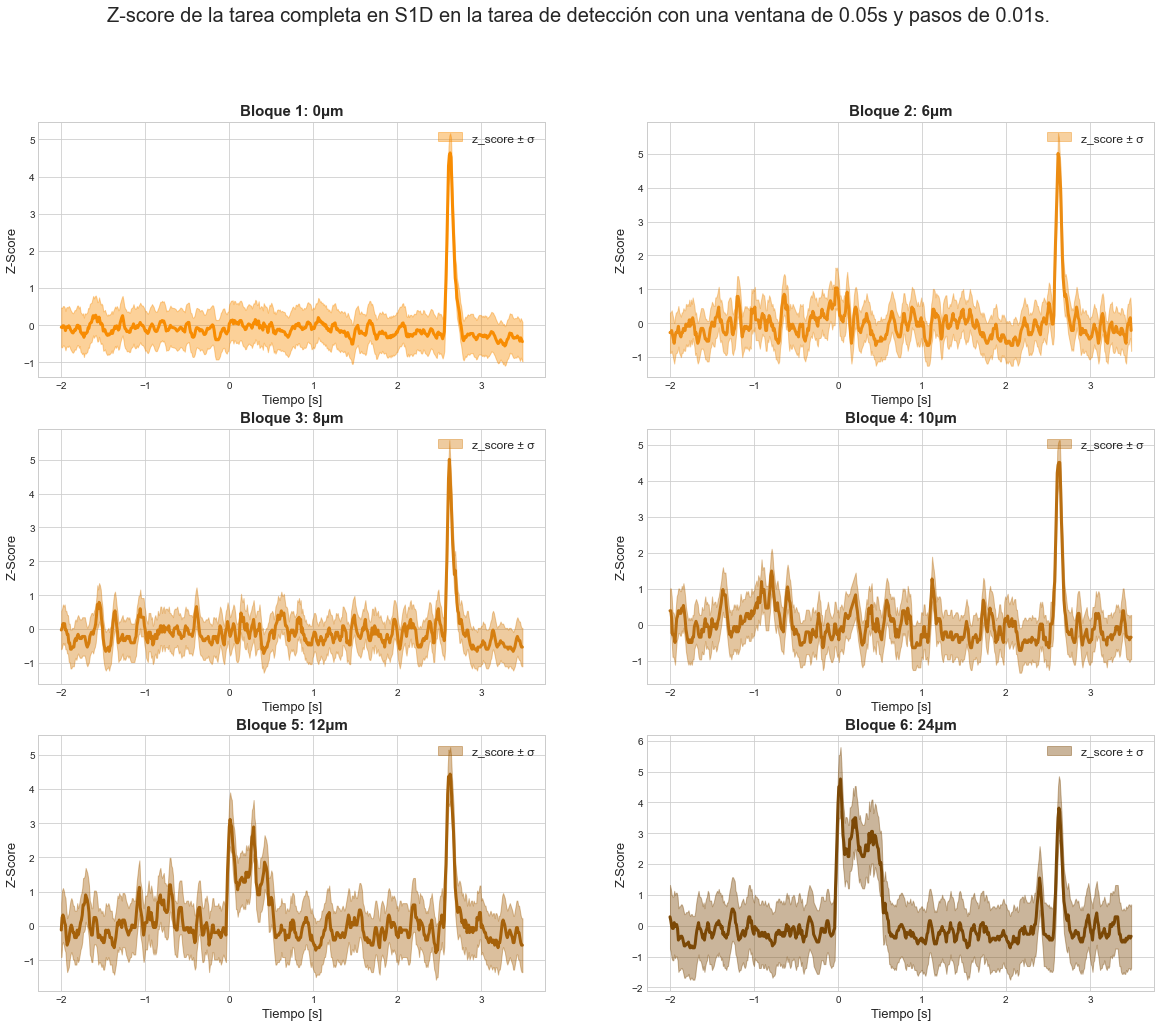

In [35]:
neurona = ['tarea completa','S1D']
colores_zs = ["#f88c02","#ec8c12","#d57e10","#b96e10","#a5610a","#7b4806"]
nombre_graf = 'z_score_completa_det_s1D'
ancho_vent = 0.05
paso_tiempo = 0.01
nombre_archivo = 'Practica2_Estadistica/Neu_Det_S1D.csv'
lista_de_clase = lista_de_reduc_s1d
fun = total_espigas_bloque
graficas_zscore_det_todas_ventanas(nombre_archivo,lista_de_clase,fun,ancho_vent,paso_tiempo,neurona,colores_zs,nombre_graf)

(b) Obten y gráfica el z-score (para cada neurona y clase) usando la tasa de las ventanas
comprendidas entre -2s y 0s (a este tipo de tasa le llamamos tasa basal) y todos los
ensayos (k = 60) para calcular el valor medio y la desviación estándar con las que
se computa la transformada z en cada clase.

In [36]:
def reducto_clases_range(lista_de_bloques_data,inf,sup):
    lista_bloques_agrupados = []
    listas_de_bloques_red = []
    listas_de_bloques_red_1 = []
    listas_de_bloques_red_2 = []
    listas_de_bloques_red_3 = []


    for i in range(len(lista_de_bloques_data[0])):
        data = lista_de_bloques_data[0][i][inf:sup]
        listas_de_bloques_red.append(data)

    for i in range(len(lista_de_bloques_data[1])):
        data_1 = lista_de_bloques_data[1][i][inf:sup]
        listas_de_bloques_red_1.append(data_1)    

    for i in range(len(lista_de_bloques_data[2])):
        data_2 = lista_de_bloques_data[2][i][inf:sup]
        listas_de_bloques_red_2.append(data_2)     

    for i in range(len(lista_de_bloques_data[3])):
        data_3 = lista_de_bloques_data[3][i][inf:sup]
        listas_de_bloques_red_3.append(data_3)  
  

    lista_bloques_agrupados.append(listas_de_bloques_red)
    lista_bloques_agrupados.append(listas_de_bloques_red_1)
    lista_bloques_agrupados.append(listas_de_bloques_red_2)
    lista_bloques_agrupados.append(listas_de_bloques_red_3)


    return lista_bloques_agrupados

In [37]:
def graficas_zscore_basal(lista_de_clase,fun,basal,ancho_vent,paso_tiempo,neurona,colores_zs,nombre_graf):

        TotalEventos_basal = fun(basal,ancho_vent)
        Total_espigas = fun(lista_de_clase,ancho_vent)
        
        clase_1 =  Total_espigas[0:15]
        clase_2 =  Total_espigas[15:30]
        clase_3 =  Total_espigas[30:45]
        clase_4 =  Total_espigas[45:60]
    
        mean_data = np.mean(TotalEventos_basal) #µ
        std_data  = np.std(TotalEventos_basal) #σ 
        
        Z_clase1 = Z_score(clase_1,mean_data,std_data)
        Z_clase2 = Z_score(clase_2,mean_data,std_data)
        Z_clase3 = Z_score(clase_3,mean_data,std_data)
        Z_clase4 = Z_score(clase_4,mean_data,std_data)
    
        ZProm_clase1 = np.mean(Z_clase1,axis=0) 
        Z_mas_1 = ZProm_clase1 + np.std(ZProm_clase1)
        Z_menos_1 = ZProm_clase1 - np.std(ZProm_clase1)
        
        ZProm_clase2 = np.mean(Z_clase2,axis=0) 
        Z_mas_2 = ZProm_clase2 + np.std(ZProm_clase2)
        Z_menos_2 = ZProm_clase2 - np.std(ZProm_clase2)
        
        ZProm_clase3 = np.mean(Z_clase3,axis=0) 
        Z_mas_3 = ZProm_clase3 + np.std(ZProm_clase3)
        Z_menos_3 = ZProm_clase3 - np.std(ZProm_clase3)
        
        ZProm_clase4 = np.mean(Z_clase4,axis=0) 
        Z_mas_4 = ZProm_clase4 + np.std(ZProm_clase4)
        Z_menos_4 = ZProm_clase4 - np.std(ZProm_clase4)
        
        fig=plt.figure(figsize=(19,11)) #ancho,largo
        fig.suptitle(f"Z-score de la {neurona[0]} en {neurona[1]} de discriminación de patrones con una ventana de {ancho_vent}s y pasos de {paso_tiempo}s.",fontsize=20)
        axs=fig.subplots(2,2)
        tiempos_dpc = np.arange(-2,8,paso_tiempo)
        
        axs[0,0].plot(tiempos_dpc,ZProm_clase1,linewidth=3,color=colores_zs[0])
        axs[0,0].fill_between(tiempos_dpc,Z_mas_1,Z_menos_1,color=colores_zs[0],alpha=0.4,label = 'z_score ± σ')
        axs[0,0].set_title("Clase 1",fontsize=15,fontweight="bold")
        axs[0,0].set_xlabel("Tiempo [s]",fontsize=13)
        axs[0,0].set_ylabel("Z-Score",fontsize=13)
        axs[0,0].legend(fontsize=12)
        
        axs[0,1].plot(tiempos_dpc,ZProm_clase2,linewidth=3,color=colores_zs[1])
        axs[0,1].fill_between(tiempos_dpc,Z_mas_2,Z_menos_2,color=colores_zs[1],alpha=0.4,label = 'z_score ± σ')
        axs[0,1].set_title("Clase 2",fontsize=15,fontweight="bold")
        axs[0,1].set_xlabel("Tiempo [s]",fontsize=13)
        axs[0,1].set_ylabel("Z-Score",fontsize=13)
        axs[0,1].legend(fontsize=12)
        
        axs[1,0].plot(tiempos_dpc,ZProm_clase3,linewidth=3,color=colores_zs[2])
        axs[1,0].fill_between(tiempos_dpc,Z_mas_3,Z_menos_3,color=colores_zs[2],alpha=0.4,label = 'z_score ± σ')
        axs[1,0].set_title("Clase 3",fontsize=15,fontweight="bold")
        axs[1,0].set_xlabel("Tiempo [s]",fontsize=13)
        axs[1,0].set_ylabel("Z-Score",fontsize=13)
        axs[1,0].legend(fontsize=12)
        
        axs[1,1].plot(tiempos_dpc,ZProm_clase4,linewidth=3,color=colores_zs[3])
        axs[1,1].fill_between(tiempos_dpc,Z_mas_4,Z_menos_4,color=colores_zs[3],alpha=0.4,label = 'z_score ± σ')
        axs[1,1].set_title("Clase 4",fontsize=15,fontweight="bold")
        axs[1,1].set_xlabel("Tiempo [s]",fontsize=13)
        axs[1,1].set_ylabel("Z-Score",fontsize=13)
        axs[1,1].legend(fontsize=12)
    
        plt.savefig(nombre_graf)
        plt.show()

In [38]:
#Para calcular el z-score de la tasa basal para todos los ensayos necesitamos utilizar los tiempos de -2s a 0s 
lista_tiempos = Ctiempos.particiones_temporales([[-2,-1.8]],0.04,-2,8,0.2)
lista_de_clase_dpc1,array_df_tasa_disparo_dpc1 = tasa_disparo_clases_agrupadas(tiempos_neudpc_1,-2,8,0.2,0.04)
lista_basal_dpc1 = reducto_clases_range(lista_de_clase_dpc1,0,46)

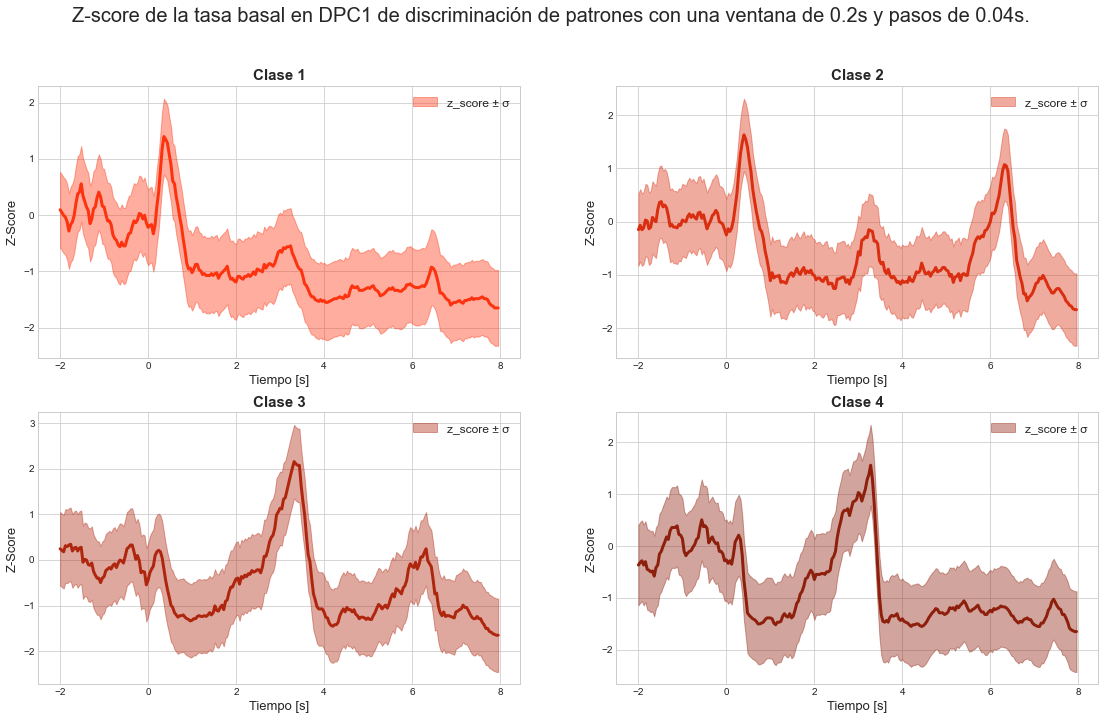

In [39]:
neurona = ['tasa basal','DPC1']
colores_zs = ["#fd320e","#da2e10","#af260e","#8d1f0c"]
nombre_graf = 'z_score_completa_dpc1_basal'
ancho_vent = 0.2
paso_tiempo = 0.04
array_clases = array_df_tasa_disparo_dpc1
lista_de_clase = lista_de_clase_dpc1
basal = lista_basal_dpc1
fun =  Total_eventos_dpc
graficas_zscore_basal(lista_de_clase,fun,basal,ancho_vent,paso_tiempo,neurona,colores_zs,nombre_graf)

In [40]:
lista_tiempos = Ctiempos.particiones_temporales([[-2,-1.8]],0.04,-2,8,0.2)
lista_de_clase_dpc2, array_df_tasa_disparo_dpc2 = tasa_disparo_clases_agrupadas(tiempos_neudpc_2,-2,8,0.2,0.04)
lista_basal_dpc2 = reducto_clases_range(lista_de_clase_dpc2,0,46)

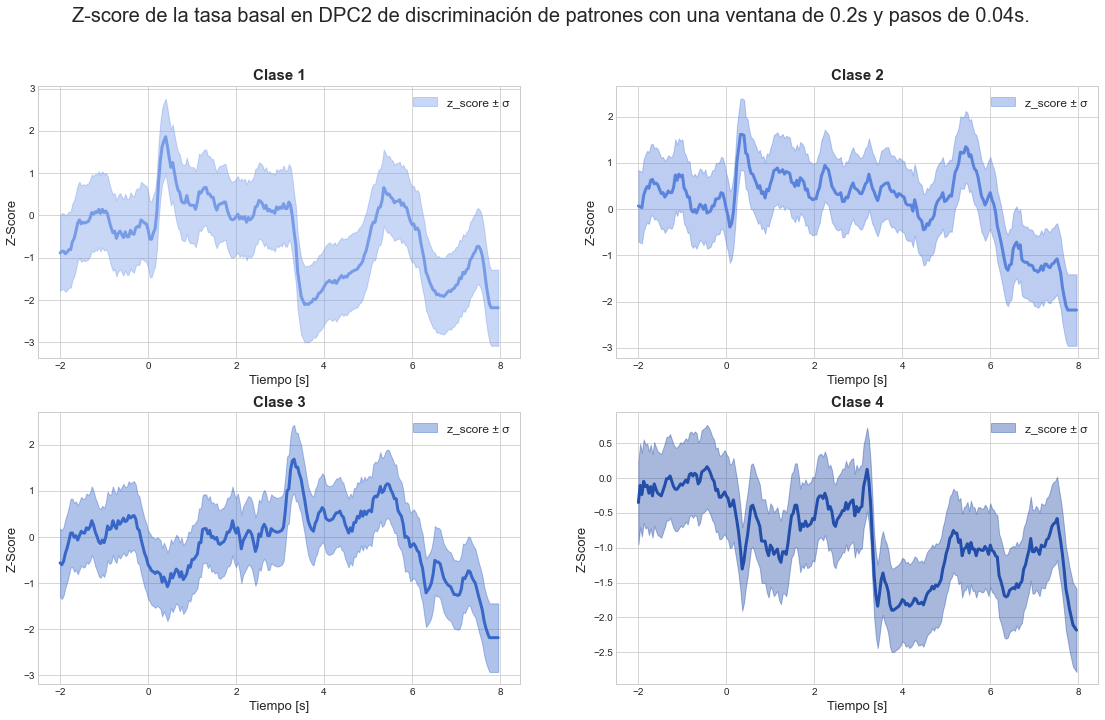

In [41]:
neurona = ['tasa basal','DPC2']
colores_zs = ["#779be7","#5983dc","#3967c8","#234ea9"]
nombre_graf = 'z_score_completa_dpc2_basal'
ancho_vent = 0.2
paso_tiempo = 0.04
array_clases = array_df_tasa_disparo_dpc2
#array_clases = array_df_tasa_disparo_dpc2
fun = Total_eventos_dpc
basal = lista_basal_dpc2
graficas_zscore_basal(lista_de_clase_dpc2,fun,basal,ancho_vent,paso_tiempo,neurona,colores_zs, nombre_graf)

In [42]:
lista_tiempos = Ctiempos.particiones_temporales([[-2,-1.95]],0.01,-2,8,0.05)
lista_de_clase_s1,array_df_tasa_disparo_s1 = tasa_disparo_clases_agrupadas(tiempos_neus1,-2,8,0.05,0.01)
lista_basal_s1 = reducto_clases_range(lista_de_clase_s1,0,46)

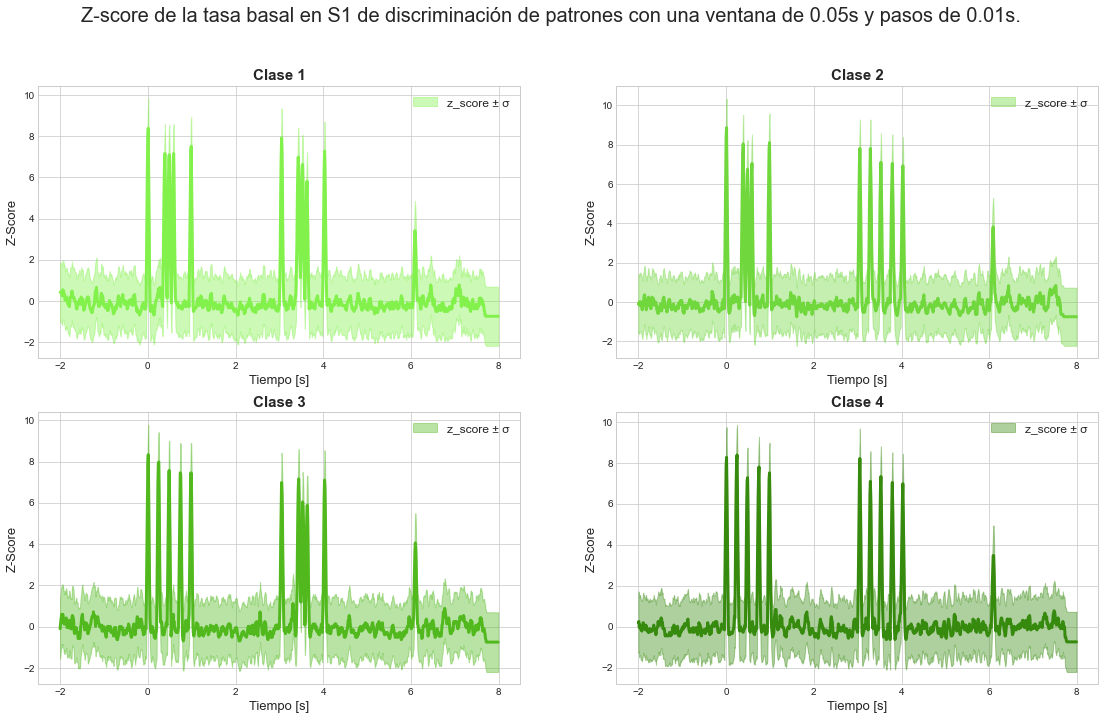

In [43]:
neurona = ['tasa basal','S1']
colores_zs = ["#83f14c","#70d73d","#51b91e","#368a0d"]
nombre_graf = 'z_score_completa_s1_basal'
ancho_vent = 0.05
paso_tiempo = 0.01
array_clases = array_df_tasa_disparo_s1
lista_de_clase = lista_de_clase_s1
fun = Total_eventos_dpc_mod
basal = lista_basal_s1
graficas_zscore_basal(lista_de_clase_s1,fun,basal,ancho_vent,paso_tiempo,neurona,colores_zs,nombre_graf)

In [44]:
def reducto_bloques_range(lista_de_bloques_data,inf,sup):
    lista_bloques_agrupados = []
    listas_de_bloques_red = []
    listas_de_bloques_red_1 = []
    listas_de_bloques_red_2 = []
    listas_de_bloques_red_3 = []
    listas_de_bloques_red_4 = []
    listas_de_bloques_red_5 = []

    for i in range(len(lista_de_bloques_data[0])):
        data = lista_de_bloques_data[0][i][inf:sup]
        listas_de_bloques_red.append(data)

    for i in range(len(lista_de_bloques_data[1])):
        data_1 = lista_de_bloques_data[1][i][inf:sup]
        listas_de_bloques_red_1.append(data_1)    

    for i in range(len(lista_de_bloques_data[2])):
        data_2 = lista_de_bloques_data[2][i][inf:sup]
        listas_de_bloques_red_2.append(data_2)     

    for i in range(len(lista_de_bloques_data[3])):
        data_3 = lista_de_bloques_data[3][i][inf:sup]
        listas_de_bloques_red_3.append(data_3)  

    for i in range(len(lista_de_bloques_data[4])):
        data_4 = lista_de_bloques_data[4][i][inf:sup]
        listas_de_bloques_red_4.append(data_4)    

    for i in range(len(lista_de_bloques_data[5])):
        data_5 = lista_de_bloques_data[5][i][inf:sup]
        listas_de_bloques_red_5.append(data_5)    

    lista_bloques_agrupados.append(listas_de_bloques_red)
    lista_bloques_agrupados.append(listas_de_bloques_red_1)
    lista_bloques_agrupados.append(listas_de_bloques_red_2)
    lista_bloques_agrupados.append(listas_de_bloques_red_3)
    lista_bloques_agrupados.append(listas_de_bloques_red_4)
    lista_bloques_agrupados.append(listas_de_bloques_red_5)

    return lista_bloques_agrupados

In [45]:
def graficas_zscore_det_basal(nombre_archivo,lista_de_clase,fun,basal,ancho_vent,paso_tiempo,neurona,colores_zs,nombre_graf):
        
        List_archivo = []
        with open(nombre_archivo,'r') as f:
            reader = csv.reader(f,delimiter='\n')
            for i,line in enumerate(reader):
                List_archivo.append(line)
    
        indices_vacios = []
        for i in range(len(List_archivo)):
            if not List_archivo[i]:
                indices_vacios.append(i)
                
        TotalEventos_det = fun(lista_de_clase,ancho_vent)
        bloque1 = TotalEventos_det[:indices_vacios[0]]
        bloque2 = TotalEventos_det[indices_vacios[0]:(indices_vacios[1]-1)]
        bloque3 = TotalEventos_det[(indices_vacios[1]-1):(indices_vacios[2]-2)]
        bloque4 = TotalEventos_det[(indices_vacios[2]-2):(indices_vacios[3]-3)]
        bloque5 = TotalEventos_det[(indices_vacios[3]-3):(indices_vacios[4]-4)]
        bloque6 = TotalEventos_det[(indices_vacios[4]-4):]
        
        TotalEventos_basal = fun(basal,ancho_vent)
    
        mean_data = np.mean(TotalEventos_basal) #µ
        std_data  = np.std(TotalEventos_basal) #σ 
        
        Z_clase1 = Z_score(bloque1,mean_data,std_data)
        Z_clase2 = Z_score(bloque2,mean_data,std_data)
        Z_clase3 = Z_score(bloque3,mean_data,std_data)
        Z_clase4 = Z_score(bloque4,mean_data,std_data)
        Z_clase5 = Z_score(bloque5,mean_data,std_data)
        Z_clase6 = Z_score(bloque6,mean_data,std_data)
    
        ZProm_clase1 = np.mean(Z_clase1,axis=0) 
        Z_mas_1 = ZProm_clase1 + np.std(ZProm_clase1)
        Z_menos_1 = ZProm_clase1 - np.std(ZProm_clase1)
        
        ZProm_clase2 = np.mean(Z_clase2,axis=0) 
        Z_mas_2 = ZProm_clase2 + np.std(ZProm_clase2)
        Z_menos_2 = ZProm_clase2 - np.std(ZProm_clase2)
        
        ZProm_clase3 = np.mean(Z_clase3,axis=0) 
        Z_mas_3 = ZProm_clase3 + np.std(ZProm_clase3)
        Z_menos_3 = ZProm_clase3 - np.std(ZProm_clase3)
        
        ZProm_clase4 = np.mean(Z_clase4,axis=0) 
        Z_mas_4 = ZProm_clase4 + np.std(ZProm_clase4)
        Z_menos_4 = ZProm_clase4 - np.std(ZProm_clase4)
        
        ZProm_clase5 = np.mean(Z_clase5,axis=0) 
        Z_mas_5 = ZProm_clase5 + np.std(ZProm_clase5)
        Z_menos_5 = ZProm_clase5 - np.std(ZProm_clase5)
        
        ZProm_clase6 = np.mean(Z_clase6,axis=0) 
        Z_mas_6 = ZProm_clase6 + np.std(ZProm_clase6)
        Z_menos_6 = ZProm_clase6 - np.std(ZProm_clase6)
        
        fig=plt.figure(figsize=(20,16)) #ancho,largo
        fig.suptitle(f"Z-score de la {neurona[0]} en {neurona[1]} en la tarea de detección con una ventana de {ancho_vent}s y pasos de {paso_tiempo}s.",fontsize=20)
        axs=fig.subplots(3,2)
        tiempos_dpc = np.arange(-2,3.5,paso_tiempo)
       
        axs[0,0].plot(tiempos_dpc,ZProm_clase1,linewidth=3,color=colores_zs[0])
        axs[0,0].fill_between(tiempos_dpc,Z_mas_1,Z_menos_1,color=colores_zs[0],alpha=0.4,label = 'z_score ± σ')
        axs[0,0].set_title("Bloque 1: 0μm",fontsize=15,fontweight="bold")
        axs[0,0].set_xlabel("Tiempo [s]",fontsize=13)
        axs[0,0].set_ylabel("Z-Score",fontsize=13)
        axs[0,0].legend(fontsize=12)
        
        axs[0,1].plot(tiempos_dpc,ZProm_clase2,linewidth=3,color=colores_zs[1])
        axs[0,1].fill_between(tiempos_dpc,Z_mas_2,Z_menos_2,color=colores_zs[1],alpha=0.4,label = 'z_score ± σ')
        axs[0,1].set_title("Bloque 2: 6μm",fontsize=15,fontweight="bold")
        axs[0,1].set_xlabel("Tiempo [s]",fontsize=13)
        axs[0,1].set_ylabel("Z-Score",fontsize=13)
        axs[0,1].legend(fontsize=12)
        
        axs[1,0].plot(tiempos_dpc,ZProm_clase3,linewidth=3,color=colores_zs[2])
        axs[1,0].fill_between(tiempos_dpc,Z_mas_3,Z_menos_3,color=colores_zs[2],alpha=0.4,label = 'z_score ± σ')
        axs[1,0].set_title("Bloque 3: 8μm",fontsize=15,fontweight="bold")
        axs[1,0].set_xlabel("Tiempo [s]",fontsize=13)
        axs[1,0].set_ylabel("Z-Score",fontsize=13)
        axs[1,0].legend(fontsize=12)
        
        axs[1,1].plot(tiempos_dpc,ZProm_clase4,linewidth=3,color=colores_zs[3])
        axs[1,1].fill_between(tiempos_dpc,Z_mas_4,Z_menos_4,color=colores_zs[3],alpha=0.4,label = 'z_score ± σ')
        axs[1,1].set_title("Bloque 4: 10μm",fontsize=15,fontweight="bold")
        axs[1,1].set_xlabel("Tiempo [s]",fontsize=13)
        axs[1,1].set_ylabel("Z-Score",fontsize=13)
        axs[1,1].legend(fontsize=12)
    
        axs[2,0].plot(tiempos_dpc,ZProm_clase5,linewidth=3,color=colores_zs[4])
        axs[2,0].fill_between(tiempos_dpc,Z_mas_5,Z_menos_5,color=colores_zs[4],alpha=0.4,label = 'z_score ± σ')
        axs[2,0].set_title("Bloque 5: 12μm",fontsize=15,fontweight="bold")
        axs[2,0].set_xlabel("Tiempo [s]",fontsize=13)
        axs[2,0].set_ylabel("Z-Score",fontsize=13)
        axs[2,0].legend(fontsize=12)
        
        axs[2,1].plot(tiempos_dpc,ZProm_clase6,linewidth=3,color=colores_zs[5])
        axs[2,1].fill_between(tiempos_dpc,Z_mas_6,Z_menos_6,color=colores_zs[5],alpha=0.4,label = 'z_score ± σ')
        axs[2,1].set_title("Bloque 6: 24μm",fontsize=15,fontweight="bold")
        axs[2,1].set_xlabel("Tiempo [s]",fontsize=13)
        axs[2,1].set_ylabel("Z-Score",fontsize=13)
        axs[2,1].legend(fontsize=12)
    
        plt.savefig(nombre_graf)
        plt.show()

In [46]:
lista_tiempos = Ctiempos.particiones_temporales([[-6.5,-6.45]],0.01,-6.5,4.5,0.05)
lista_de_bloques_s1b = espigas_bloques_agrupados('Practica2_Estadistica/Neu_Det_S1B.csv',-6.5,4.5,0.05,0.01)

In [47]:
lista_de_reduc_s1b = reducto_bloques(lista_de_bloques_s1b)
lista_basal_s1b = reducto_bloques_range(lista_de_bloques_s1b,450,651)

In [48]:
bloque1_s1b  = pd.Series(np.mean(total_espigas_bloque(lista_de_bloques_s1b,0.05)[:50],axis=0))
tiempos = pd.Series(np.arange(-6.5,4.5,0.01))
tren_de_espigas ={
        'tiempo': tiempos,
        'tasa_disparo': bloque1_s1b
    }
df_tasa_disparo= pd.DataFrame(tren_de_espigas)
#df_tasa_disparo[450:651] de -2 a 0

<ipython-input-25-7b2f2c65c200>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arreglo_bloques = np.array(lista_de_bloques)


<ipython-input-25-7b2f2c65c200>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arreglo_bloques = np.array(lista_de_bloques)


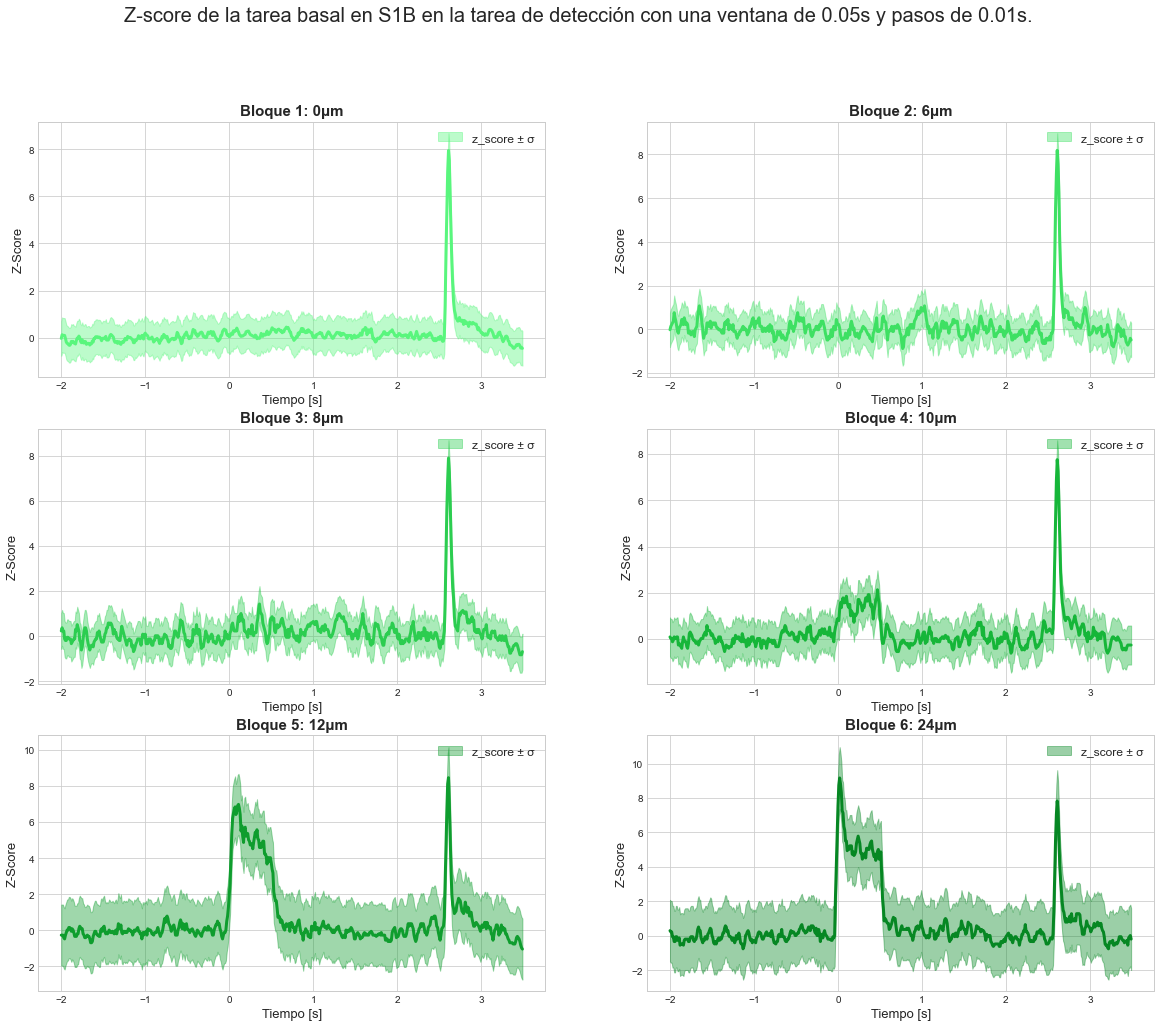

In [49]:
neurona = ['tarea basal','S1B']
colores_zs = ["#59f67d","#3ee063","#2ccd50","#16b639","#0f9d2e","#068723"]
nombre_graf = 'z_score_completa_det_s1b_basal'
ancho_vent = 0.05
paso_tiempo = 0.01
nombre_archivo = 'Practica2_Estadistica/Neu_Det_S1B.csv'
lista_de_clase = lista_de_reduc_s1b
fun = total_espigas_bloque
basal = lista_basal_s1b
graficas_zscore_det_basal(nombre_archivo,lista_de_clase,fun,basal,ancho_vent,paso_tiempo,neurona,colores_zs,nombre_graf)

In [50]:
lista_tiempos = Ctiempos.particiones_temporales([[-6.5,-6.45]],0.01,-6.5,4.5,0.05)
lista_de_bloques_s1d = espigas_bloques_agrupados('Practica2_Estadistica/Neu_Det_S1D.csv',-6.5,4.5,0.05,0.01)

In [51]:
lista_de_reduc_s1d = reducto_bloques(lista_de_bloques_s1d)
lista_basal_s1d = reducto_bloques_range(lista_de_bloques_s1d,450,651)

<ipython-input-25-7b2f2c65c200>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arreglo_bloques = np.array(lista_de_bloques)


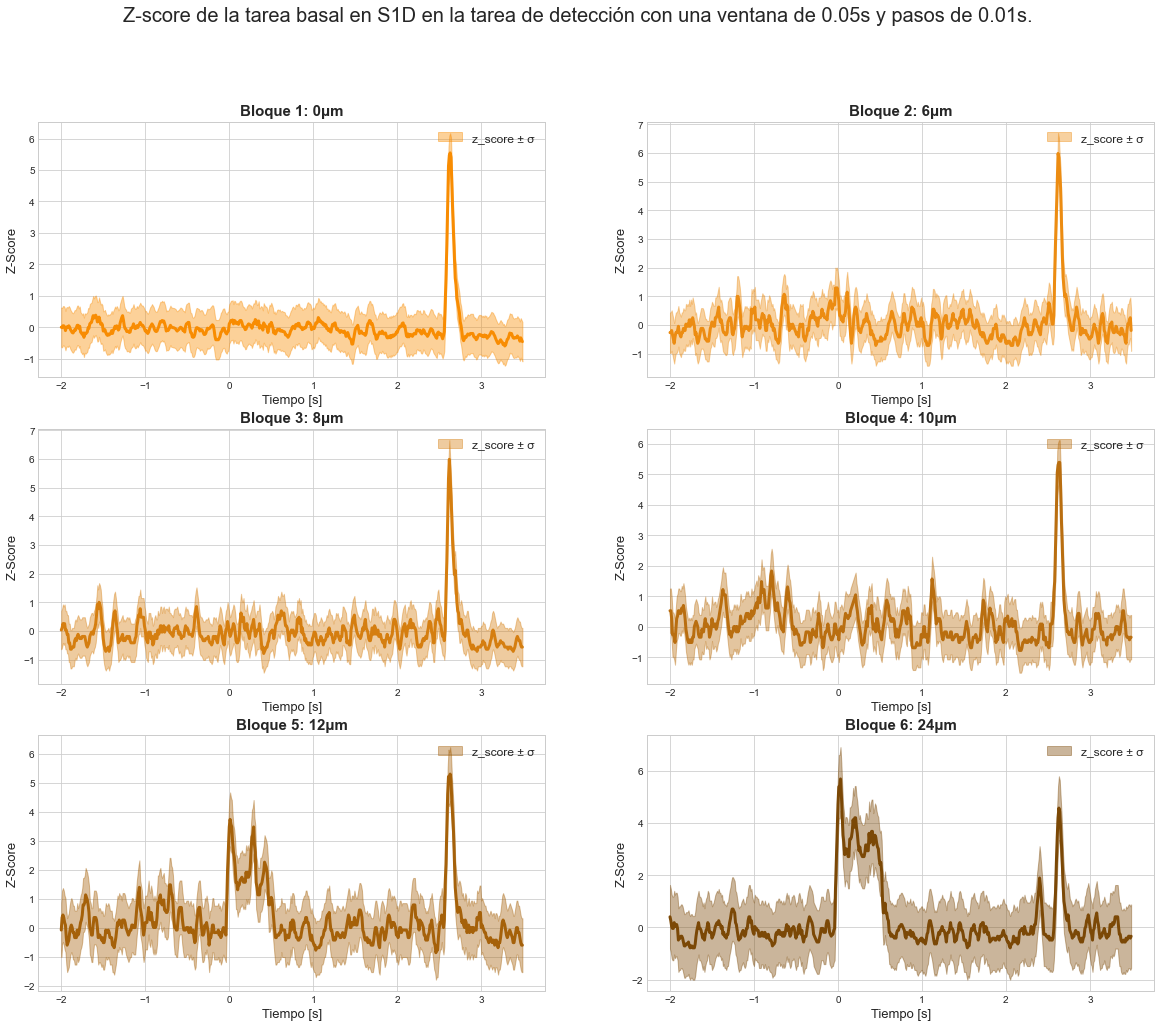

In [52]:
neurona = ['tarea basal','S1D']
colores_zs = ["#f88c02","#ec8c12","#d57e10","#b96e10","#a5610a","#7b4806"]
nombre_graf = 'z_score_completa_det_s1d_basal'
ancho_vent = 0.05
paso_tiempo = 0.01
nombre_archivo = 'Practica2_Estadistica/Neu_Det_S1D.csv'
lista_de_clase = lista_de_reduc_s1d
fun = total_espigas_bloque
basal = lista_basal_s1d
graficas_zscore_det_basal(nombre_archivo,lista_de_clase,fun,basal,ancho_vent,paso_tiempo,neurona,colores_zs,nombre_graf)

(c) Obten y gráfica el z-score (para cada neurona y clase) usando la tasa de cada ventana
de tiempo particular y todos los ensayos para calcular el valor medio y la desviación
estándar con las que se computa la transformada z en cada tiempo y clase. Esto
es, para computar el z-score en el tiempo t va a usar la media y desviación de la
tasa en el tiempo t (una sola ventana). Además grafique la tasa transformada de
algunos ensayos de cada una de las condiciones como ejemplos.

(d) Obten y gráfica el z-score (para cada neurona y clase) usando la tasa de cada
ventana particular y los ensayos correspondientes a cada clase para calcular el valor
medio y la desviación estándar con las que se computa la transformada z en cada
tiempo y clase. Para este inciso, además grafique la tasa transformada de algunos
ensayos de cada una de las clases como ejemplos.


(e) Discuta: ¿qué diferencias observa entre los distintos cálculos realizados?

(f) Repita el primer inciso, pero ahora utilizando ventanas de 200ms con pasos de
40sms para las tres neuronas de S1 y ventanas 50 ms con pasos de 10 ms para las
dos neuronas de DPC. ¿Qué diferencias observa?

In [53]:
lista_tiempos = Ctiempos.particiones_temporales([[-2,-1.95]],0.01,-2,8,0.05)
lista_de_clase_dpc1,array_df_tasa_disparo_dpc1 = tasa_disparo_clases_agrupadas(tiempos_neudpc_1,-2,8,0.05,0.01)

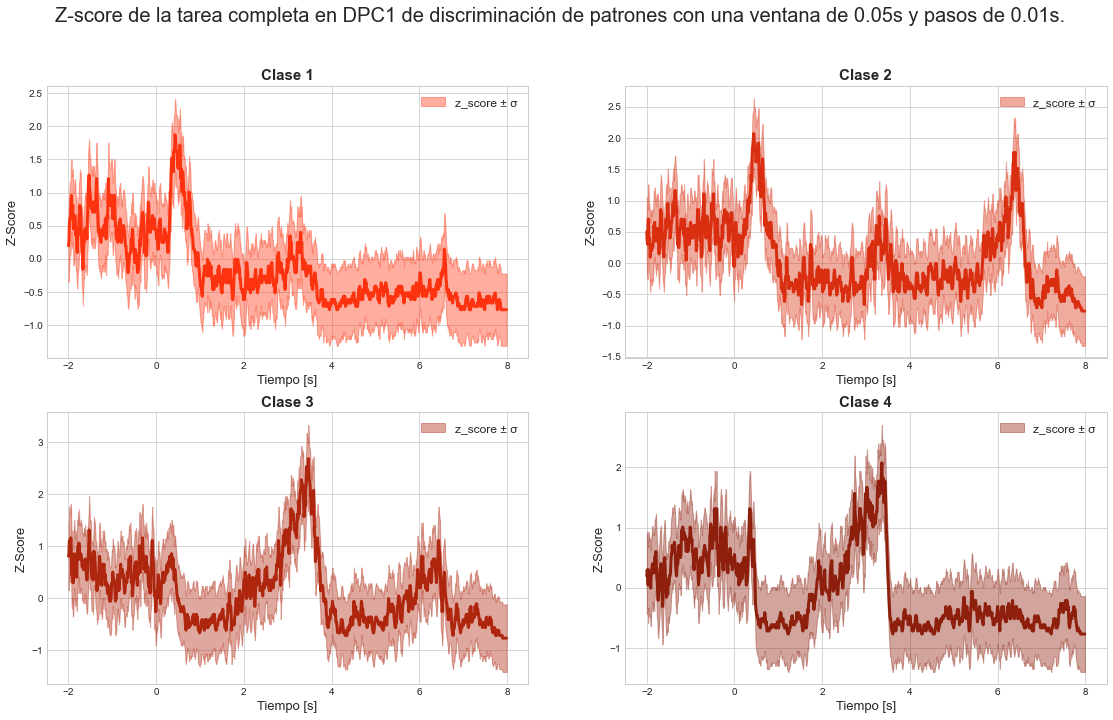

In [54]:
neurona = ['tarea completa','DPC1']
colores_zs = ["#fd320e","#da2e10","#af260e","#8d1f0c"]
nombre_graf = 'z_score_completa_dpc1_50'
ancho_vent = 0.05
paso_tiempo = 0.01
array_clases = array_df_tasa_disparo_dpc1
lista_de_clase = lista_de_clase_dpc1
fun = Total_eventos_dpc_mod
graficas_zscore_dpc_todas_ventanas(lista_de_clase,fun,ancho_vent,paso_tiempo,neurona,colores_zs,nombre_graf)

In [55]:
lista_tiempos = Ctiempos.particiones_temporales([[-2,-1.95]],0.01,-2,8,0.05)
lista_de_clase_dpc2,array_df_tasa_disparo_dpc2 = tasa_disparo_clases_agrupadas(tiempos_neudpc_2,-2,8,0.05,0.01)

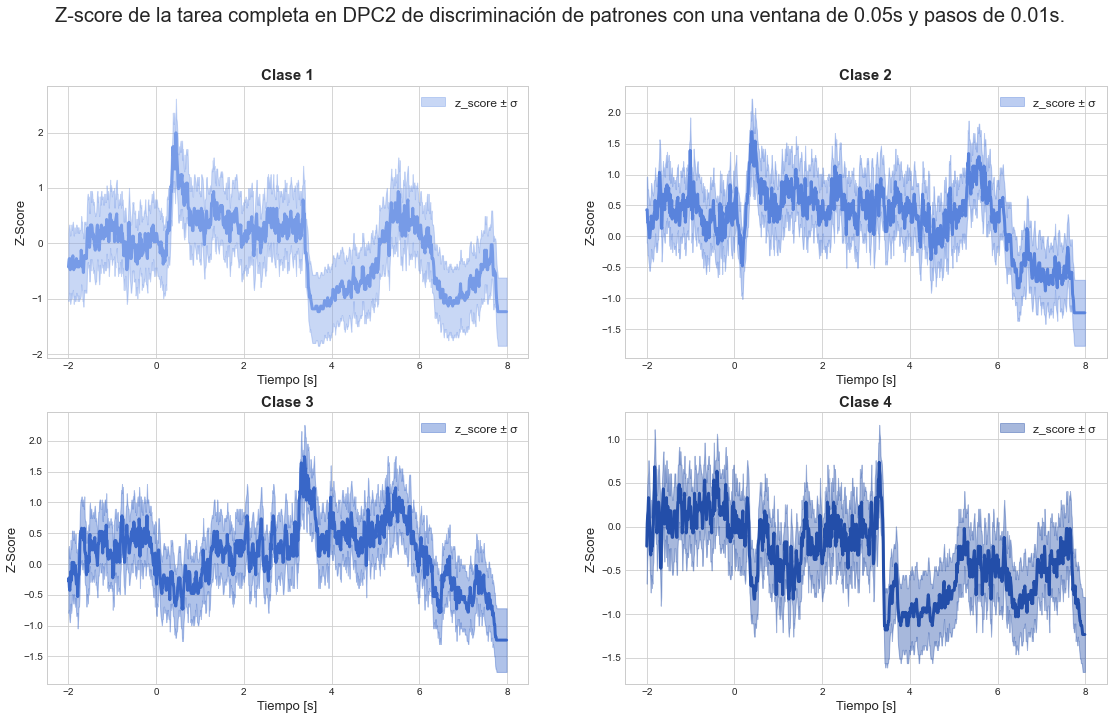

In [56]:
neurona = ['tarea completa','DPC2']
colores_zs = ["#779be7","#5983dc","#3967c8","#234ea9"]
nombre_graf = 'z_score_completa_dpc2_50'
ancho_vent = 0.05
paso_tiempo = 0.01
array_clases = array_df_tasa_disparo_dpc2
lista_de_clase = lista_de_clase_dpc2
fun = Total_eventos_dpc_mod
graficas_zscore_dpc_todas_ventanas(lista_de_clase,fun,ancho_vent,paso_tiempo,neurona,colores_zs, nombre_graf)

In [57]:
lista_tiempos = Ctiempos.particiones_temporales([[-2,-1.8]],0.04,-2,8,0.2)
lista_de_clase_s1,array_df_tasa_disparo_s1 = tasa_disparo_clases_agrupadas(tiempos_neus1,-2,8,0.2,0.04)

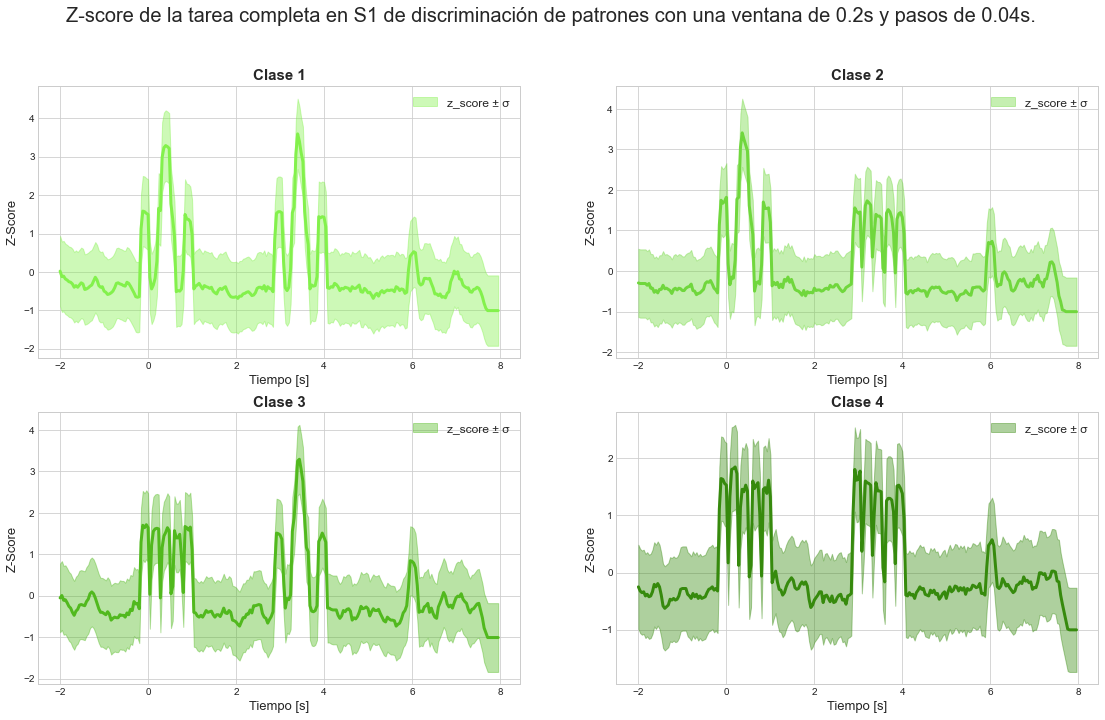

In [58]:
neurona = ['tarea completa','S1']
colores_zs = ["#83f14c","#70d73d","#51b91e","#368a0d"]
nombre_graf = 'z_score_completa_s1'
ancho_vent = 0.2
paso_tiempo = 0.04
array_clases = array_df_tasa_disparo_s1
lista_de_clase = lista_de_clase_s1
fun = Total_eventos_dpc_mod
graficas_zscore_dpc_todas_ventanas(lista_de_clase_s1,fun,ancho_vent,paso_tiempo,neurona,colores_zs,nombre_graf)

In [59]:
lista_tiempos = Ctiempos.particiones_temporales([[-6.5,-6.3]],0.04,-6.5,4.5,0.2)
lista_de_bloques_s1d = espigas_bloques_agrupados('Practica2_Estadistica/Neu_Det_S1D.csv',-6.5,4.5,0.2,0.04)

In [60]:
bloque1_s1d  = pd.Series(np.mean(total_espigas_bloque(lista_de_bloques_s1d,0.2)[:34],axis=0))
tiempos = pd.Series(np.arange(-6.5,4.5,0.04))
tren_de_espigas ={
        'tiempo': tiempos,
        'tasa_disparo': bloque1_s1d
    }
df_tasa_disparo= pd.DataFrame(tren_de_espigas)
df_tasa_disparo[112:250]
len(np.arange(-2,3.5,0.04))

<ipython-input-25-7b2f2c65c200>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arreglo_bloques = np.array(lista_de_bloques)


138

In [61]:
lista_de_bloques_red_s1d = reducto_bloques_range(lista_de_bloques_s1d,112,250)

<ipython-input-25-7b2f2c65c200>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arreglo_bloques = np.array(lista_de_bloques)


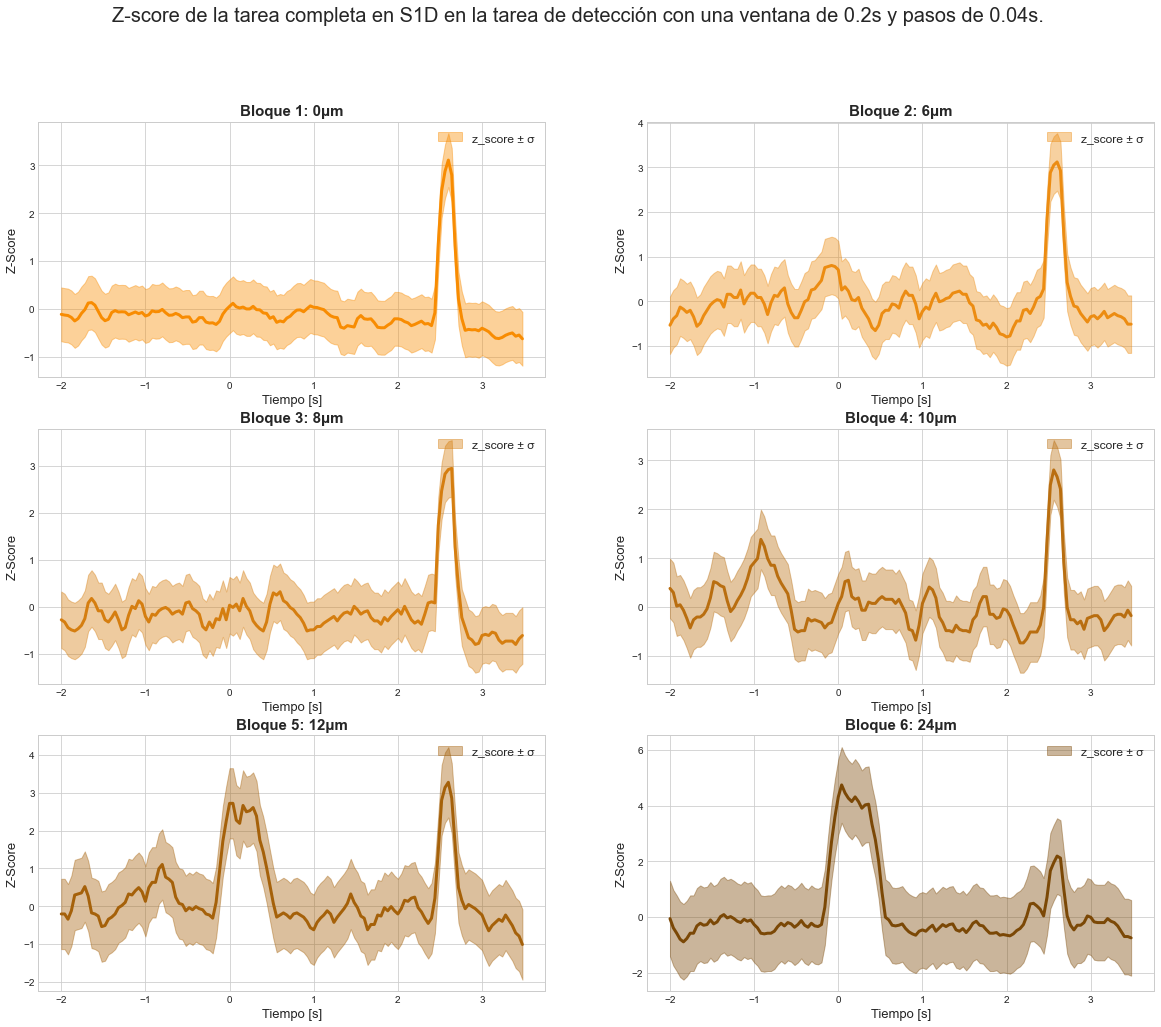

In [62]:
neurona = ['tarea completa','S1D']
colores_zs = ["#f88c02","#ec8c12","#d57e10","#b96e10","#a5610a","#7b4806"]
nombre_graf = 'z_score_completa_det_s1D_200'
ancho_vent = 0.2
paso_tiempo = 0.04
nombre_archivo = 'Practica2_Estadistica/Neu_Det_S1D.csv'
lista_de_clase = lista_de_bloques_red_s1d
fun = total_espigas_bloque
graficas_zscore_det_todas_ventanas(nombre_archivo,lista_de_clase,fun,ancho_vent,paso_tiempo,neurona,colores_zs,nombre_graf)

In [63]:
lista_tiempos = Ctiempos.particiones_temporales([[-6.5,-6.3]],0.04,-6.5,4.5,0.2)
lista_de_bloques_s1b = espigas_bloques_agrupados('Practica2_Estadistica/Neu_Det_S1B.csv',-6.5,4.5,0.2,0.04)

In [64]:
lista_de_bloques_red_s1b = reducto_bloques_range(lista_de_bloques_s1b,112,250)

<ipython-input-25-7b2f2c65c200>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arreglo_bloques = np.array(lista_de_bloques)


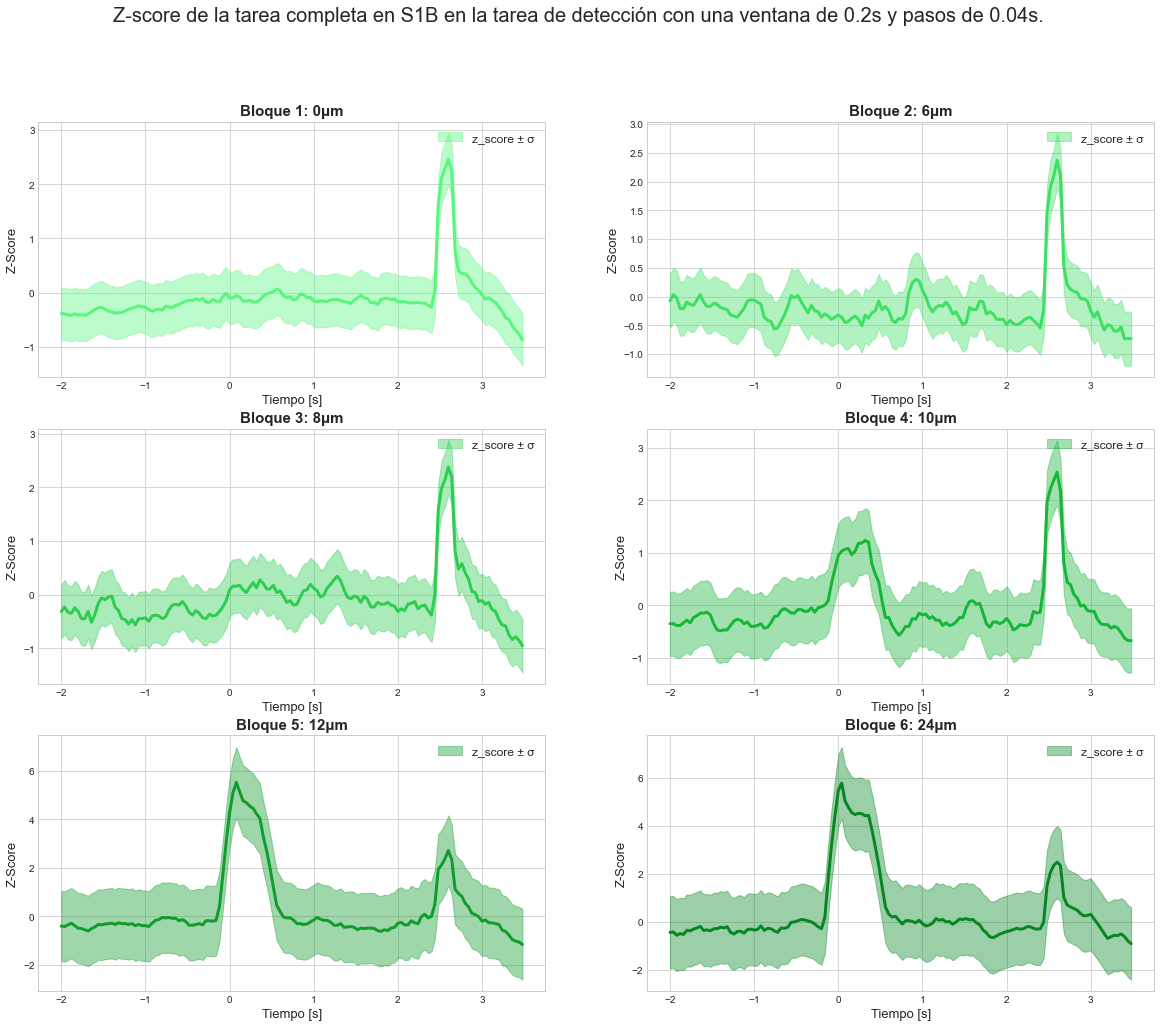

In [65]:
neurona = ['tarea completa','S1B']
colores_zs = ["#59f67d","#3ee063","#2ccd50","#16b639","#0f9d2e","#068723"]
nombre_graf = 'z_score_completa_det_s1b_200'
ancho_vent = 0.2
paso_tiempo = 0.04
nombre_archivo = 'Practica2_Estadistica/Neu_Det_S1B.csv'
lista_de_clase = lista_de_bloques_red_s1b
fun = total_espigas_bloque
graficas_zscore_det_todas_ventanas(nombre_archivo,lista_de_clase,fun,ancho_vent,paso_tiempo,neurona,colores_zs,nombre_graf)

<h2> Ejercicio 2. </h2>


Este ejercicio también es sobre la transformada z, pero ahora además
vamos a juntar el z-score de neuronas distintas. Vamos a utilizar datos de diez
neuronas de S1; la que ya trabajamos (TiemposNeuS1.csv) y nueve nuevas
neuronas: ```TiemposNeuS1A.csv```, ```TiemposNeuS1B.csv```, ```TiemposNeuS1C.csv```,
```TiemposNeuS1D.csv```, ```TiemposNeuS1E.csv```, ```TiemposNeuS1F.csv```,
```TiemposNeuS1G.csv```, ```TiemposNeuS1H.csv``` y ```TiemposNeuS1I.csv```. Antes de
empezar, calcule las tasas de disparo de las diez neuronas usando ventanas de 50ms,
con pasos de 10 ms.

(a) Calcule el z-score de las neuronas (A, B, C, D y F) como en el punto a) del ejercicio
anterior. ¿Qué diferencias observa entre neuronas?

(b) Junte las diez neuronas utilizando el procedimiento explicado en clase y la
transformada del inciso anterior. Exprese el resultado en z-score promedio y tasa
promedio poblacional.

(c) Calcule la transformada z de las neuronas (A, B, C, D y F) como en el punto b)
del ejercicio anterior. ¿Qué diferencias observa entre neuronas y con los resultados
del punto a)?

(d) Junte las diez neuronas con el procedimiento explicado en clase y la transformada
del punto c). Exprese el resultado en z-score y tasa poblacional promedios.

In [66]:
tiempos_neus1_a    = pd.read_csv('Practica2_Estadistica/TiemposNeuS1A.csv',header=None, sep='\n')
tiempos_neus1_b    = pd.read_csv('Practica2_Estadistica/TiemposNeuS1B.csv',header=None, sep='\n')
tiempos_neus1_c    = pd.read_csv('Practica2_Estadistica/TiemposNeuS1C.csv',header=None, sep='\n')
tiempos_neus1_d    = pd.read_csv('Practica2_Estadistica/TiemposNeuS1D.csv',header=None, sep='\n')
tiempos_neus1_e    = pd.read_csv('Practica2_Estadistica/TiemposNeuS1E.csv',header=None, sep='\n')
tiempos_neus1_f    = pd.read_csv('Practica2_Estadistica/TiemposNeuS1F.csv',header=None, sep='\n')
tiempos_neus1_g    = pd.read_csv('Practica2_Estadistica/TiemposNeuS1G.csv',header=None, sep='\n')
tiempos_neus1_h    = pd.read_csv('Practica2_Estadistica/TiemposNeuS1H.csv',header=None, sep='\n')
tiempos_neus1_i    = pd.read_csv('Practica2_Estadistica/TiemposNeuS1I.csv',header=None, sep='\n')

In [67]:
lista_tiempos = Ctiempos.particiones_temporales([[-2,-1.95]],0.01,-2,8,0.05)

lista_de_clase_s1a,array_df_tasa_disparo_s1a = tasa_disparo_clases_agrupadas(tiempos_neus1_a,-2,8,0.05,0.01)
lista_de_clase_s1b,array_df_tasa_disparo_s1b = tasa_disparo_clases_agrupadas(tiempos_neus1_b,-2,8,0.05,0.01)
lista_de_clase_s1c,array_df_tasa_disparo_s1c = tasa_disparo_clases_agrupadas(tiempos_neus1_c,-2,8,0.05,0.01)
lista_de_clase_s1d,array_df_tasa_disparo_s1d = tasa_disparo_clases_agrupadas(tiempos_neus1_d,-2,8,0.05,0.01)
lista_de_clase_s1e,array_df_tasa_disparo_s1e = tasa_disparo_clases_agrupadas(tiempos_neus1_e,-2,8,0.05,0.01)
lista_de_clase_s1f,array_df_tasa_disparo_s1f = tasa_disparo_clases_agrupadas(tiempos_neus1_f,-2,8,0.05,0.01)
lista_de_clase_s1g,array_df_tasa_disparo_s1g = tasa_disparo_clases_agrupadas(tiempos_neus1_g,-2,8,0.05,0.01)
lista_de_clase_s1h,array_df_tasa_disparo_s1h = tasa_disparo_clases_agrupadas(tiempos_neus1_h,-2,8,0.05,0.01)
lista_de_clase_s1i,array_df_tasa_disparo_s1i = tasa_disparo_clases_agrupadas(tiempos_neus1_i,-2,8,0.05,0.01)

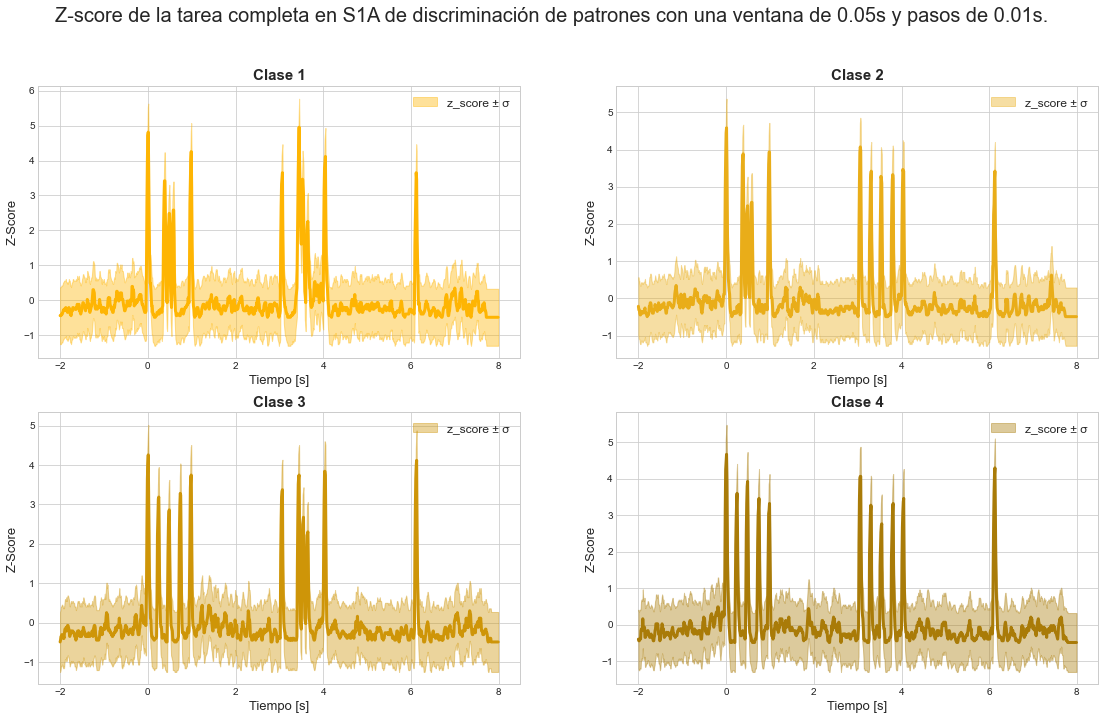

In [68]:
neurona = ['tarea completa','S1A']
colores_zs = ["#feb503","#e9ad19","#ce9508","#a97b08"]
nombre_graf = 'z_score_completa_s1a'
ancho_vent = 0.05
paso_tiempo = 0.01
array_clases = array_df_tasa_disparo_s1a
lista_de_clase = lista_de_clase_s1a
fun = Total_eventos_dpc_mod
graficas_zscore_dpc_todas_ventanas(lista_de_clase,fun,ancho_vent,paso_tiempo,neurona,colores_zs,nombre_graf)

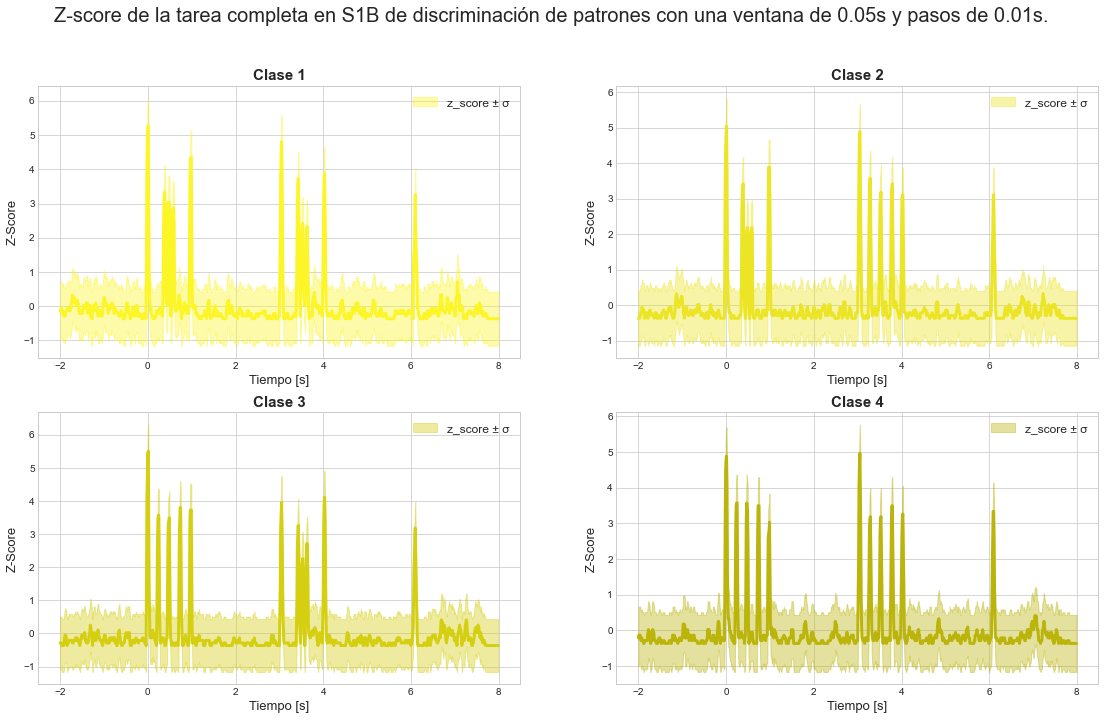

In [69]:
neurona = ['tarea completa','S1B']
colores_zs = ["#fcf628","#ebe526","#d5cf12","#bbb50b"]

nombre_graf = 'z_score_completa_s1b'
ancho_vent = 0.05
paso_tiempo = 0.01
array_clases = array_df_tasa_disparo_s1b
lista_de_clase = lista_de_clase_s1b
fun = Total_eventos_dpc_mod
graficas_zscore_dpc_todas_ventanas(lista_de_clase,fun,ancho_vent,paso_tiempo,neurona,colores_zs,nombre_graf)

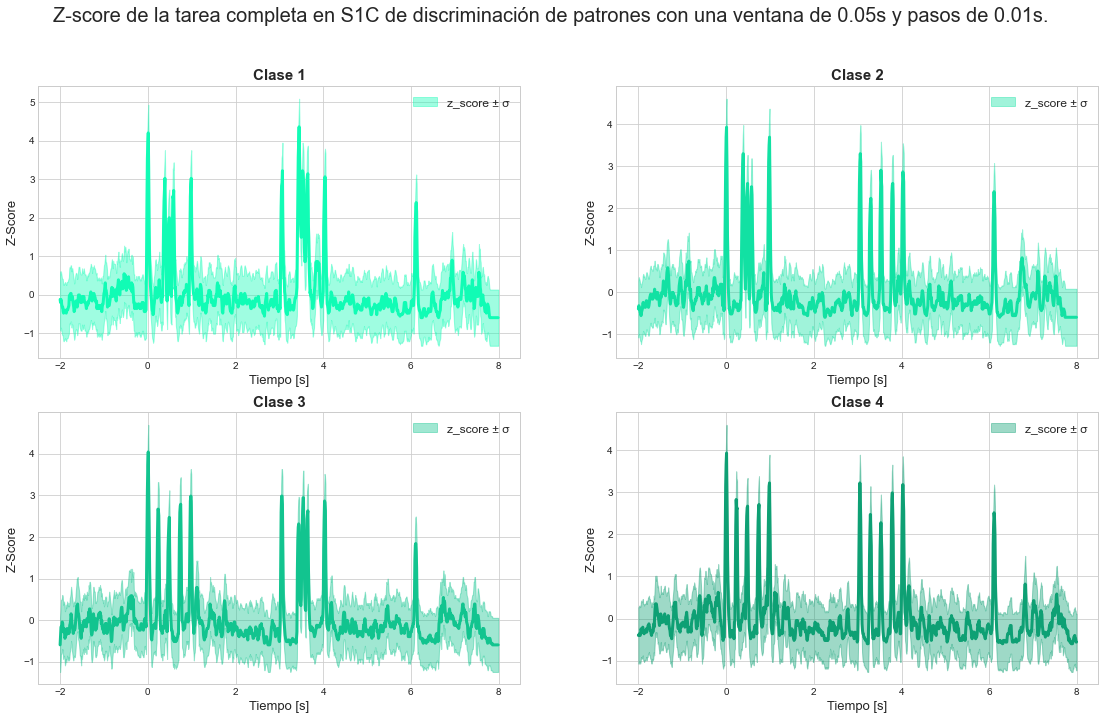

In [70]:
neurona = ['tarea completa','S1C']
colores_zs = ["#11fcb5","#12e1a3","#12c48f","#0ea074"]
nombre_graf = 'z_score_completa_s1c'
ancho_vent = 0.05
paso_tiempo = 0.01
array_clases = array_df_tasa_disparo_s1c
lista_de_clase = lista_de_clase_s1c
fun = Total_eventos_dpc_mod
graficas_zscore_dpc_todas_ventanas(lista_de_clase,fun,ancho_vent,paso_tiempo,neurona,colores_zs,nombre_graf)

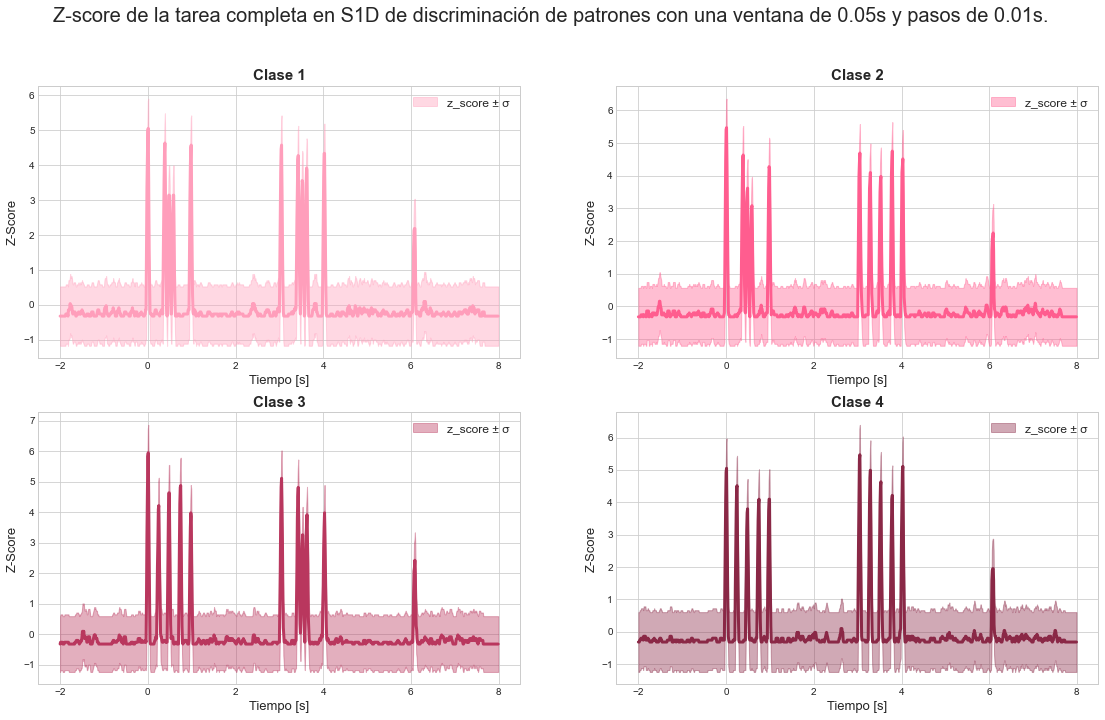

In [71]:
neurona = ['tarea completa','S1D']
colores_zs = ["#ff9ebb","#ff5d8f","#b9375e","#8a2846"]
nombre_graf = 'z_score_completa_s1d'
ancho_vent = 0.05
paso_tiempo = 0.01
array_clases = array_df_tasa_disparo_s1d
lista_de_clase = lista_de_clase_s1d
fun = Total_eventos_dpc_mod
graficas_zscore_dpc_todas_ventanas(lista_de_clase,fun,ancho_vent,paso_tiempo,neurona,colores_zs,nombre_graf)

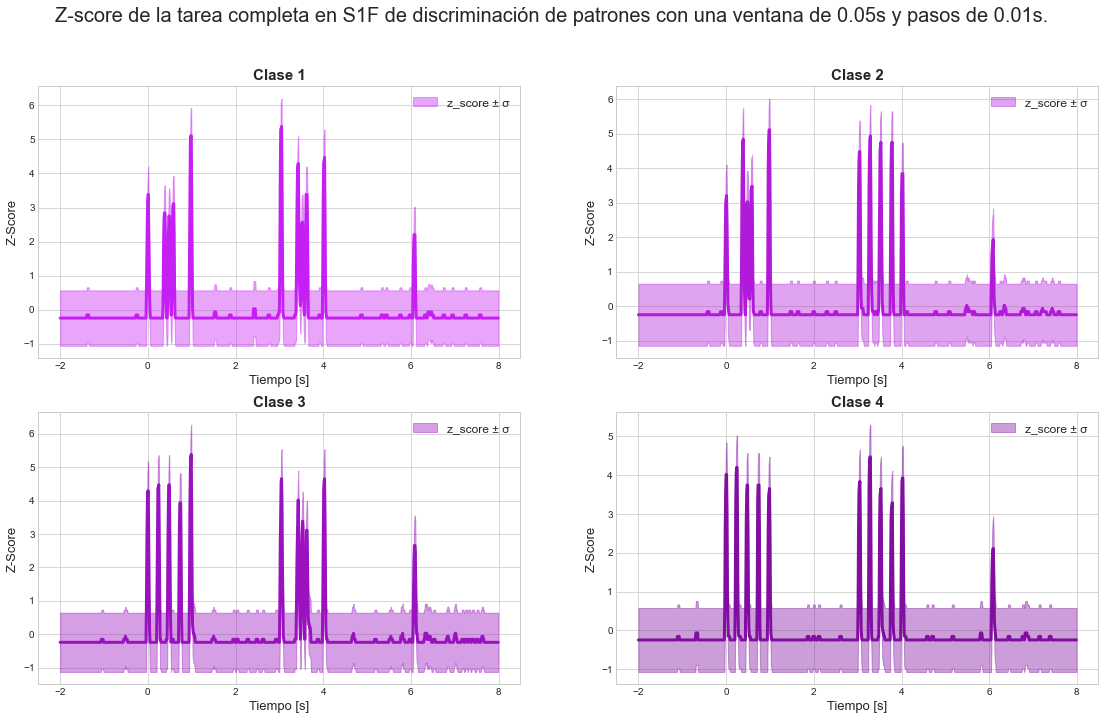

In [72]:
neurona = ['tarea completa','S1F']
colores_zs = ["#c61ff3","#b01ad8","#9a11bf","#810da1"]
nombre_graf = 'z_score_completa_s1f'
ancho_vent = 0.05
paso_tiempo = 0.01
array_clases = array_df_tasa_disparo_s1f
lista_de_clase = lista_de_clase_s1f
fun = Total_eventos_dpc_mod
graficas_zscore_dpc_todas_ventanas(lista_de_clase,fun,ancho_vent,paso_tiempo,neurona,colores_zs,nombre_graf)

<h2> Ejercicio 3. </h2>

Este ejercicio es equivalente al anterior: vamos a juntar el z-score de
neuronas distintas, pero registradas durante la tarea de detección. Los archivos
son cinco: ```DetNeuS1 A.csv```, ```DetNeuS1 B.csv```, ```DetNeuS1 C.csv```, ```DetNeuS1 D.csv``` y
```DetNeuS1 E.csv```. Antes de empezar, calcule las tasas de disparo de las diez neuronas
usando ventanas de 50ms, con pasos de 10 ms.

(a) Calcule el z-score de las neuronas B y D como en el punto a) del ejercicio anterior.
¿Qué diferencias observa entre neuronas?

(b) Junte las cinco neuronas utilizando el procedimiento explicado en clase y la
transformada del inciso anterior. Exprese el resultado en z-score promedio y tasa
promedio poblacional.

(c) Calcule la transformada z de las neuronas B y D como en el punto b) del ejercicio
anterior. ¿Qué diferencias observa entre neuronas y con los resultados del punto a)?

(d) Junte las cinco neuronas con el procedimiento explicado en clase y la transformada
del punto c). Exprese el resultado en z-score y tasa poblacional promedios.

<h2>Ejercicio 4. 

(a) Utilice los archivos de datos ```Data50g0.csv```, ```Data200g0.csv```, ```Data500g0.csv``` y
```Data200g2```. Para cada conjunto de datos calcule: el valor medio, la varianza, la
desviación estándar, el valor medio cuadrático, el tercer momento centrado y el
cuarto momento centrado. Posteriormente, utilice los histogramas de los datos
para ajustarles una distribución gaussiana. Grafique el histograma junto con la
dsitribución ajustada y reporte los valores que obtuvo para los parametros del
ajuste. Calcule la media, varianza, tercer y cuarto momentos que le corresponden a
su distribución ajustada. Responda las siguientes preguntas: ¿Qué ventana utiliza
para crear los histogramas? ¿Utiliza la misma ventana para todos los conjuntos
de datos? ¿Qué tan similares son los estimados de los momentos estadísticos
(media, varianza, tercer y cuarto momento) que obtuvo de sus datos con los que le
corresponden a sus distribuciones ajustadas? ¿Considera que los ajustes son buenos?

In [73]:
#Abrimos el archivo 
data50g0 =  open('Practica2_Estadistica/Data50g0.txt','r')

In [74]:
#Creamos la función leer_archivo_array la cual lee el archivo y almacena los datos en un arreglo de python
def leer_archivo_array(nombre_archivo):
        archivo_abierto = open(nombre_archivo, "r")         #abre y lee el archivo 
        array_archivo = archivo_abierto.read().splitlines() #lee el archivo, separa cada línea y la almacena en una lista
        archivo_abierto.close()
        return np.array(array_archivo)                      #convierte la lista en array 

In [75]:
data50g0 = leer_archivo_array('Practica2_Estadistica/Data50g0.txt')

In [76]:
type(data50g0)

numpy.ndarray

In [77]:
#Transformamos los datos a flotantes 
data50g0 = data50g0.astype(np.float)

In [78]:
#Creamos la función que calcula el valor medio cuadrático o en inglés Root Mean Square
def RMS_data(data):
    suma_cuadrados =  np.square(np.array(data)).sum()    #suma del cuadrado de los datos 
    cociente = suma_cuadrados / len(data)
    return np.sqrt(cociente)

In [79]:
#creamos la función que obtiene el momento centrado de los datos 
def momento_centrado(data,no_momento):
    diferencias = data - np.mean(data)
    diferencias_elevadas = pow(diferencias,no_momento)
    cociente = diferencias_elevadas.sum()/len(data)
    return cociente

In [80]:
#Creamos la función que obtiene los valores estadísticos solicitados
def estadisticos_data(data):

    media_data  = np.mean(data)
    var_data    = np.var(data)
    std_data    = np.std(data)
    data_RMS    = RMS_data(data)
    tercer_data = momento_centrado(data,3)
    cuarto_data = momento_centrado(data,4)
    
    return print(f'Los valores estadísticos para los datos son:\n Media : {media_data}. \n Varianza: {var_data}. \n Desviación estándar: {std_data}.\n Valor medio cuadrático: {data_RMS}.\n Tercer momento centrado: {tercer_data}.\n Cuarto momento centrado: {cuarto_data}.')


In [81]:
estadisticos_data(data50g0)

Los valores estadísticos para los datos son:
 Media : -0.017676420643316045. 
 Varianza: 0.010036583519963465. 
 Desviación estándar: 0.10018275061088842.
 Valor medio cuadrático: 0.1017302283823393.
 Tercer momento centrado: 0.00045408177050653087.
 Cuarto momento centrado: 0.0003458746431844583.


In [82]:
#Leemos los archivos y convertimos los datos a flotantes 
data200g0 = leer_archivo_array('Practica2_Estadistica/Data200g0.txt')
data500g0 = leer_archivo_array('Practica2_Estadistica/Data500g0.txt')
data200g2 = leer_archivo_array('Practica2_Estadistica/Data200g2.txt') 

data200g0 = data200g0.astype(np.float)
data500g0 = data500g0.astype(np.float)
data200g2 = data200g2.astype(np.float)

In [83]:
estadisticos_data(data200g0)

Los valores estadísticos para los datos son:
 Media : 0.0007213161189891826. 
 Varianza: 0.03436977416651941. 
 Desviación estándar: 0.185390868616875.
 Valor medio cuadrático: 0.185392271854743.
 Tercer momento centrado: 0.0008469472495462993.
 Cuarto momento centrado: 0.0036291638287074372.


In [84]:
estadisticos_data(data500g0)

Los valores estadísticos para los datos son:
 Media : -0.002724028626183076. 
 Varianza: 0.009144536379695815. 
 Desviación estándar: 0.09562706928320984.
 Valor medio cuadrático: 0.09566585969744944.
 Tercer momento centrado: -7.357554838932872e-05.
 Cuarto momento centrado: 0.00023985265576389951.


In [85]:
estadisticos_data(data200g2)

Los valores estadísticos para los datos son:
 Media : 1.9944513261590575. 
 Varianza: 0.010180506442374853. 
 Desviación estándar: 0.10089849573891006.
 Valor medio cuadrático: 1.9970019025679464.
 Tercer momento centrado: -0.00018316085061487983.
 Cuarto momento centrado: 0.00029932722132495663.


In [86]:
#Creamos una función gaussiana para calcular el ajuste con la distribución gaussiana 
def gaussian(x, mean, std):
    return ( 1 / (std*np.sqrt(2*math.pi)) ) * np.exp( - ((x - mean)**2/ (2*std**2)) )

In [87]:
#Lista que contiene los arreglos de datos a estudiar 
conjunto_datos = [data50g0,data200g0,data500g0,data200g2]

In [88]:
#Ajustes para la estética de las gráficas 
plt.rcParams['savefig.bbox'] = "tight"
style.use('seaborn-whitegrid') or plt.style.use('seaborn-whitegrid')

In [89]:
#Ajustes para la estética de las gráficas
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})

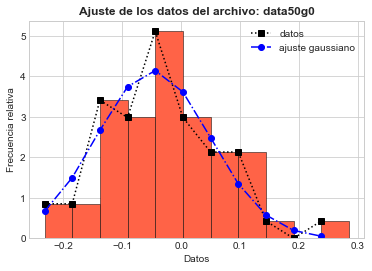

Estadisticos de data50g0:
Total de datos: 50
Los valores estadísticos para los datos son:
 Media : -0.017676420643316045. 
 Varianza: 0.010036583519963465. 
 Desviación estándar: 0.10018275061088842.
 Valor medio cuadrático: 0.1017302283823393.
 Tercer momento centrado: 0.00045408177050653087.
 Cuarto momento centrado: 0.0003458746431844583.
	
Los valores estadísticos del ajuste son:
Media: -0.047422138126429716 
Desviación estandar: 0.09622328301043068
Tercer momento: -0.0014238790877989633
Cuarto momento: 0.00038717222336024206
Cuarto momento centrado: 0.00025718280943799754
Número de bins: 11
Ancho de la ventana 0.046922789042404545




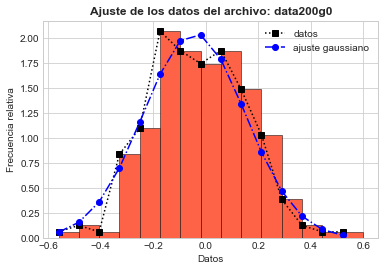

Estadisticos de data200g0:
Total de datos: 200
Los valores estadísticos para los datos son:
 Media : 0.0007213161189891826. 
 Varianza: 0.03436977416651941. 
 Desviación estándar: 0.185390868616875.
 Valor medio cuadrático: 0.185392271854743.
 Tercer momento centrado: 0.0008469472495462993.
 Cuarto momento centrado: 0.0036291638287074372.
	
Los valores estadísticos del ajuste son:
Media: -0.04470190274098533 
Desviación estandar: 0.19452763817165566
Tercer momento: -0.005164020403800448
Cuarto momento: 0.004753514332186883
Cuarto momento centrado: 0.00429582429996246
Número de bins: 15
Ancho de la ventana 0.07726486565483281




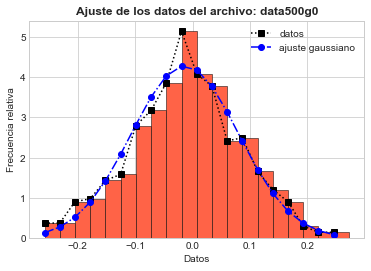

Estadisticos de data500g0:
Total de datos: 500
Los valores estadísticos para los datos son:
 Media : -0.002724028626183076. 
 Varianza: 0.009144536379695815. 
 Desviación estándar: 0.09562706928320984.
 Valor medio cuadrático: 0.09566585969744944.
 Tercer momento centrado: -7.357554838932872e-05.
 Cuarto momento centrado: 0.00023985265576389951.
	
Los valores estadísticos del ajuste son:
Media: -0.013328000625486907 
Desviación estandar: 0.09328454631500666
Tercer momento: -0.0003503085748684175
Cuarto momento: 0.00023648102702086086
Cuarto momento centrado: 0.00022717475561756794
Número de bins: 20
Ancho de la ventana 0.02648707143899487




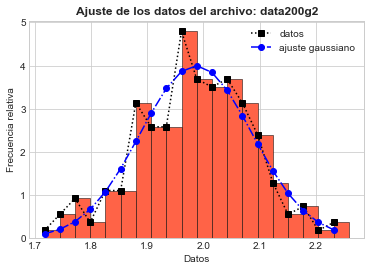

Estadisticos de data200g2:
Total de datos: 200
Los valores estadísticos para los datos son:
 Media : 1.9944513261590575. 
 Varianza: 0.010180506442374853. 
 Desviación estándar: 0.10089849573891006.
 Valor medio cuadrático: 1.9970019025679464.
 Tercer momento centrado: -0.00018316085061487983.
 Cuarto momento centrado: 0.00029932722132495663.
	
Los valores estadísticos del ajuste son:
Media: 1.9868371640291005 
Desviación estandar: 0.09975746952002021
Tercer momento: 7.902399593639426
Cuarto momento: 15.8189302153081
Cuarto momento centrado: 0.00029710020491761945
Número de bins: 20
Ancho de la ventana 0.027099794560413892




In [90]:
conjunto_datos = [data50g0,data200g0,data500g0,data200g2]
nombre_datos = ['data50g0', 'data200g0', 'data500g0' , 'data200g2' ]
nombre_grafos = ['data50g0_gauss', 'data200g0_gauss', 'data500g0_gauss' , 'data200g2_gauss']

Bins=[11,15,20,20]
for i in range(len(conjunto_datos)):
    
    mean = np.mean(conjunto_datos[i]) #media de los datos
    std =  np.std(conjunto_datos[i])  #desviación estándar de los datos
    
    ocurrencias, bins = np.histogram(conjunto_datos[i],bins=Bins[i]) #ocurrencias tiene un array con la cuenta de valores 
    #que caen en el bin i.e. la frecuencia, bins es un arreglo con los extremos de las divisiones 
   
    ancho_bin = bins[1]- bins[0] # como los bins están igualmente espaciados, para calcular el ancho basta con restar cualquier 
    #par de extremos consecutivos
    
    total_datos =  len(conjunto_datos[i]) #El número total de datos 
    
    normalizados = (ocurrencias / total_datos) / ancho_bin   #normalizamos dividiendo la frecuencia entre el total de datos 
    #y el ancho de la ventana
    
    plt.hist(bins[:-1],bins,weights=normalizados,color= 'tomato', edgecolor = 'black',  linewidth=0.5)  
    #graficamos el histograma utilizando los datos normalizados 
   
    x = bins[:-1]  #Las divisiones 
    y = normalizados  #Datos normalizados 
    
    # curve_fit returns params :array with sum of the squared residuals of f(xdata, *params) - ydata is minimized.
    # pcov: 2-D array The estimated covariance of params. The diagonals provide the variance of the parameter estimate. 
    # p0 (optional): Initial guess for the parameters (length N).
    # En este caso params será un arreglo con el promedio y la desv. est. de los  datos ajustados 
    
    params,pcov = curve_fit(gaussian,x,y,p0=[mean,std])    #obtenemos los valores ajustados con curve_fit 
    plt.plot(x,y,'ks:',label='datos')                      #graficamos los extremos de los datos originales 
    plt.plot(x,gaussian(x,*params),'bo-.',label='ajuste gaussiano')   #de los datos ajustados 
    plt.title(f'Ajuste de los datos del archivo: {nombre_datos[i]}',fontweight="bold")
    plt.xlabel('Datos')
    plt.ylabel('Frecuencia relativa')
    plt.legend()
    plt.savefig(nombre_grafos[i])
    plt.show()
    
    #La media y la desviación estándar obtenida a partir del ajuste además del cálculo de los momentos 
    #Es importante recordar que se trata de una distribución normal (el ajuste), en una distribución normal
    #el tercer momento centrado es 0.
    media,desv = params
    tercer_mom = (media**3) + (3*media*(desv**2))
    cuarto_mom = (media**4) + (6*(media**2)*(desv**2)) + (3*(desv**4))
    cuarto_mom_cent = 3*(desv**4)
    
    
    
    print('Estadisticos de {}:'.format(nombre_datos[i]))
    print('Total de datos:', total_datos)
    estadisticos_data(conjunto_datos[i])  #estadísticos datos raw (reales)
    print('\t')
    print('Los valores estadísticos del ajuste son:')
    print('Media:',media,'\nDesviación estandar:',desv)
    print('Tercer momento:',tercer_mom )
    print('Cuarto momento:',cuarto_mom)
    print('Cuarto momento centrado:',cuarto_mom_cent)
    print('Número de bins:',Bins[i])
    print('Ancho de la ventana', ancho_bin)
    print('\n')

In [91]:
#Para obtener un histograma normalizado basta con:
#plt.hist(data50g0,bins = 11, density=True)

(b) Utilice los archivos de datos ```Data200P2.csv``` y ```Data200P4.csv```. Repita todos los
calculos y responda todas las preguntas como en el punto anterior, pero en este
caso ajuste una distribución de Poission en vez de una gaussiana. Adicionalmente,
conteste la siguiente pregunta: ¿Considera que una distribución de Poission es
apropiada para ajustar estos datos?

In [92]:
#Leemos los archivos 
data200p2 = leer_archivo_array('Practica2_Estadistica/Data200p2.txt')
data200p4 = leer_archivo_array('Practica2_Estadistica/Data200p4.txt')

In [93]:
#Cambiamos el formato de los datos a tipo flotante 
data200p2 = data200p2.astype(np.float)
data200p4 = data200p4.astype(np.float)

#Utilizando la función estadísticos obtenemos los valores estadísticos solicitados
print('Data200p2')
estadisticos_data(data200p2)
print('\n')
print('Data200p4')
estadisticos_data(data200p4)

Data200p2
Los valores estadísticos para los datos son:
 Media : 2.06. 
 Varianza: 2.0063999999999997. 
 Desviación estándar: 1.4164744967700618.
 Valor medio cuadrático: 2.5.
 Tercer momento centrado: 2.4286319999999995.
 Cuarto momento centrado: 15.243777119999997.


Data200p4
Los valores estadísticos para los datos son:
 Media : 3.97. 
 Varianza: 3.3591. 
 Desviación estándar: 1.8327847664142127.
 Valor medio cuadrático: 4.37264222181509.
 Tercer momento centrado: 0.902345999999997.
 Cuarto momento centrado: 31.830141569999995.


In [94]:
#Función que calcula el ajuste de poisson 
def poisson_ajuste(k,mu): #mu es el parámetro de forma 
    return stats.poisson.pmf(k,mu) # Función de Masa de Probabilidad 

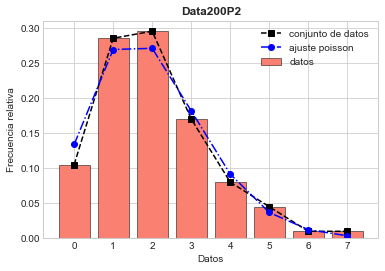

Estadisticos de Data200P2:
Los valores estadísticos para los datos son:
 Media : 2.06. 
 Varianza: 2.0063999999999997. 
 Desviación estándar: 1.4164744967700618.
 Valor medio cuadrático: 2.5.
 Tercer momento centrado: 2.4286319999999995.
 Cuarto momento centrado: 15.243777119999997.
	
Los valores estadísticos del ajuste son:
Media: [2.01274444]
Varianza:[2.01274444]
Desviación estándar: [1.41871225]
Tercer momento: 8.804731529813877
Cuarto momento centrado: [12.15342049]
Skewness: [0.70486457]
Kurtosis: [0.49683407]




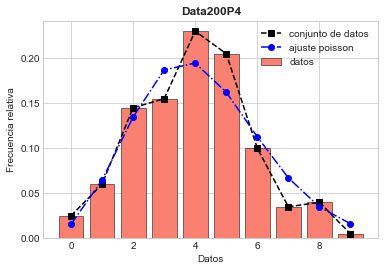

Estadisticos de Data200P4:
Los valores estadísticos para los datos son:
 Media : 3.97. 
 Varianza: 3.3591. 
 Desviación estándar: 1.8327847664142127.
 Valor medio cuadrático: 4.37264222181509.
 Tercer momento centrado: 0.902345999999997.
 Cuarto momento centrado: 31.830141569999995.
	
Los valores estadísticos del ajuste son:
Media: [4.16638058]
Varianza:[4.16638058]
Desviación estándar: [2.04117137]
Tercer momento: [86.54255923]
Cuarto momento centrado: [52.07618138]
Skewness: [0.48991477]
Kurtosis: [0.24001648]




In [95]:
# Ahora para graficar el ajuste de poisson 
datos_completos = [data200p2,data200p4]
nombre_datos = ['Data200P2','Data200P4']
nombre_grafos = ['Data200P2_poiss','Data200P4_poiss']

for i in range(len(datos_completos)):
    
    mu  = np.mean(datos_completos[i])  #promedio de cada conjunto de datos 
    x,y = np.unique(datos_completos[i],return_counts=True)
    y = y / y.sum()
    plt.bar(x,y,label='datos',color = 'salmon', edgecolor = 'black',  linewidth=0.5)
    plt.plot(x,y,'ks--',label='conjunto de datos')
    
    #funciona de la misma forma que para el ajuste gaussiano, en este caso la predicción es mu, el promedio calculado. popt es params en el gaussiano
    popt,pcov = curve_fit(poisson_ajuste,x,y,mu) 
    plt.plot(x,poisson_ajuste(x,*popt),'bo-.',label='ajuste poisson')
    med, var, sk, ku = poisson.stats(popt, moments='mvsk') 
    #Utilizaos el método stats(mu, loc=0, moments=’mv’) de poisson  	Mean(‘m’), variance(‘v’), skew(‘s’), and/or kurtosis(‘k’).
    # moments : str, optional composed of letters [‘mvsk’] specifying which moments to compute where ‘m’ = mean, ‘v’ = variance, ‘s’ = (Fisher’s) skew 
    # and ‘k’ = (Fisher’s) kurtosis. (default=’mv’)

    plt.title(nombre_datos[i],fontweight="bold") 
    plt.xlabel('Datos')
    plt.ylabel('Frecuencia relativa')
    plt.legend()
    plt.savefig(nombre_grafos[i])
    plt.show()
    
    
    # estadísticos del ajuste poisson faltantes  
    tercer = (mu**3) + (3*mu*(std**2))
    std = np.sqrt(var)
    cuarto_mom_c = 3*(std**4)


    print('Estadisticos de {}:'.format(nombre_datos[i]) )
    estadisticos_data(datos_completos[i]) #estadísticos datos raw (reales)
    print('\t')
    print('Los valores estadísticos del ajuste son:')
    print(f'Media: {med}')
    print(f'Varianza:{var}')
    print('Desviación estándar:',std)
    print('Tercer momento:',tercer)
    print('Cuarto momento centrado:',cuarto_mom_c)
    print('Skewness:',sk)
    print('Kurtosis:',ku)
    print("\n")

(c)  Ahora utilice sus dos conjuntos de datos de palabras de textos distintos. Repita todos los calculos y responda todas las preguntas como en el primer punto, pero con los siguientes cambios: no calcule el tercer ni cuarto momento;en vez de una gaussiana, ajuste una distribución de ley de potencias (power law). Preguntas adicionales: ¿Considera que una ley de potencias es apropiada para ajustar estos datos? ¿Por qué cree que no le pedimos calcular los momentos superiores?

(d) Repita el iniciso anterior, pero ahora utilice del orden de veinte mil palabras (lo que
serían ≈ mil oraciones). ¿Qué diferencias observas ahora entre las distribuciones de cada texto? ¿Qué sucede con los parámetros de los ajustes?

<h2> Ejercicio 5.

Para este ejericio va a necesitar obtener muestras de núeros aleatorios de distribuciones uniformes en tres rangos: 0-1; 0-20; y 0-300.

(a) Crear los histogramas para muestras de 100, 500 y 5000 números aleatorios, en cada uno de los rangos.

(b) Calcular el valor medio, la varianza y la desviación estándar de las muestras. Comparar los valores obtenidos con lo que usted piensa que son los valor reales.

(c) Utilizando las nueve muestras de datos generadas, calcular la probabilidad de tener un número mayor a 0.5. Utilizando las tres muestras generadas en el rango 0-20 y las tres del rango 0-300, calcular la probabilidad de que el número sea mayor a 14.
Utilizando las 3 muestras tomadas del rango 0-300, calcular la probabilidad que el número sea mayor a 220. En casa caso, comparar los resultados obtenidos cuando se toman 100, 500 o 5000 números aleatorios.

(d) Genere una gráfica de la probabilidad de tener un numero mayor que 190 en función del tamaño de la muestra, para datos tomados del rango [0, 300]. La gráfica debe mostrar las probabilidad para tamaños de muestra que vayan de 100 a 10,000 en
pasos de 100. ¿Qué puede decir de la gráfica? Discutir su convergencia.

In [96]:
#Generamos los números aleatorios para las muestras de 100,500 y 5000 
def aleatorios_uniformes(lim_inf,lim_sup):
    ran_100  = np.random.uniform(lim_inf,lim_sup,100)
    ran_500  = np.random.uniform(lim_inf,lim_sup,500)
    ran_5000 = np.random.uniform(lim_inf,lim_sup,5000)
    return ran_100, ran_500,ran_5000

In [97]:
# ======================= Histograma de los rangos  ====================================
def histograma_rangos(inf,sup,color_name,nombre_graf):
  
    vector_aleatorios = aleatorios_uniformes(inf,sup)
    nombres_datos = ['ran_100', 'ran_500','ran_5000']
         
    # Generando los histogramas
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4.5))
    fig.suptitle(f"Histograma de los datos aleatorios(uniformes) en el rango {inf}-{sup}",fontsize=14,fontweight="bold")

    # Histograma  1
    frecuencias,bins=np.histogram(vector_aleatorios[0])
    axs[0].hist(bins[:-1],bins,weights=frecuencias, color= color_name ,edgecolor = 'black',  linewidth=0.5)
    axs[0].set_title('Muestra de 100 números aleatorios')
    axs[0].set_xlabel('Datos')
    axs[0].set_ylabel('Frecuencia')

    # Histograma 2 
    frecuencias,bins=np.histogram(vector_aleatorios[1])
    axs[1].hist(bins[:-1],bins,weights= frecuencias, color= color_name,edgecolor = 'black',  linewidth=0.5)
    axs[1].set_title('Muestra de 500 números aleatorios')
    axs[1].set_xlabel('Datos')
    axs[1].set_ylabel('Frecuencia')
    
    # Histograma 3 
    frecuencias,bins = np.histogram(vector_aleatorios[2])
    axs[2].hist(bins[:-1],bins,weights=frecuencias, color= color_name ,edgecolor = 'black',  linewidth=0.5)
    axs[2].set_title('Muestra de 5000 números aleatorios')
    axs[2].set_xlabel('Datos')
    axs[2].set_ylabel('Frecuencia')
    
    plt.savefig(nombre_graf)
    plt.show()
    #plt.tight_layout();
    

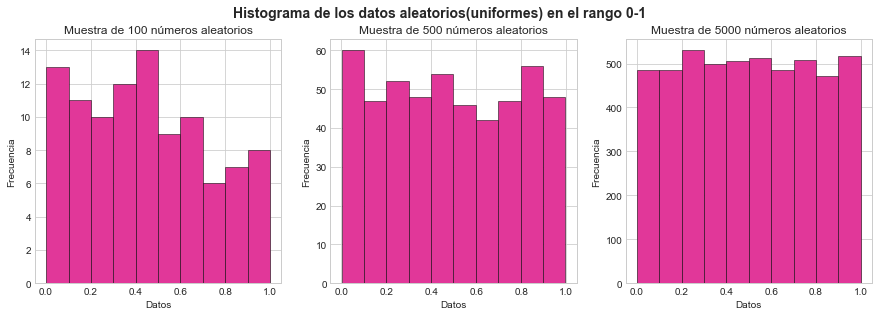

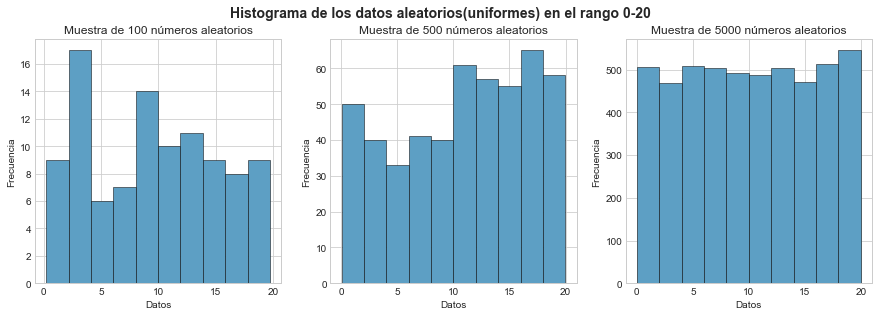

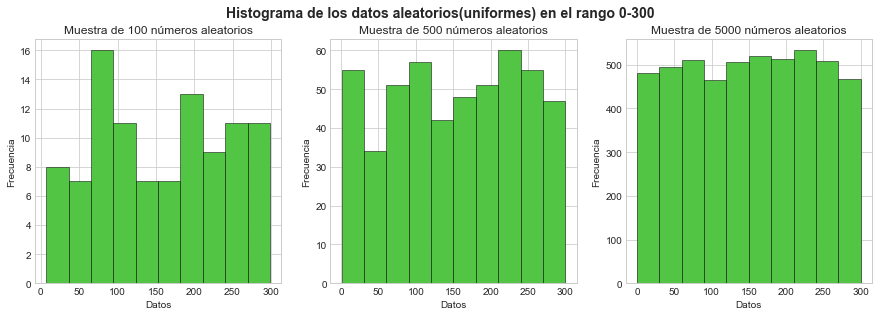

In [98]:
np.random.seed(15)  #Iniciamos con una semilla ya que vamos a generar números aleatorios y queremos resultados reproducibles
nombre_fig_1 = 'histograma_rango_01.png'
nombre_fig_20 = 'histograma_rango_020.png'
nombre_fig_300 = 'histograma_rango_0300.png'

histograma_rangos(0,1,"#e13799",nombre_fig_1)
histograma_rangos(0,20,"#5d9fc4", nombre_fig_20)
histograma_rangos(0,300,"#52c644",  nombre_fig_300)

In [99]:
#Función que calcula los estadísticos de las muestras. 
def estadisticos(data):
    mean_data = np.mean(data)
    var_data  = np.var(data)
    std_data  = np.std(data)
    
    return print(f'Media: {mean_data}.\nVarianza: {var_data}.\nDesviación estándar:{std_data}.')

In [100]:
#Función de las estadísticas de las muestras por rango
def estadisticas_por_rango(inf,sup):
    vector_aleatorios = aleatorios_uniformes(inf,sup) #vector de números aleatorios 
    nombres_datos = ['ran_100', 'ran_500','ran_5000'] 
    arreglo_estadisticos = []
    print(f'Del intervalo {inf}-{sup}:')
    for i in range(len(vector_aleatorios)):
        print(f'\nEstadísticos de los datos {nombres_datos[i]}:\t') 
        arreglo_estadisticos.append(estadisticos(vector_aleatorios[i]))  #calcula el estadístico de casa uno y los coloca en una lista 
    print('\n')   

In [101]:
np.random.seed(15)    #Iniciamos con una semilla ya que vamos a generar números aleatorios y queremos resultados reproducibles
estadisticas_por_rango(0,1)
estadisticas_por_rango(0,20)
estadisticas_por_rango(0,300)

Del intervalo 0-1:

Estadísticos de los datos ran_100:	
Media: 0.44535962125232137.
Varianza: 0.07782588236345707.
Desviación estándar:0.2789729061458425.

Estadísticos de los datos ran_500:	
Media: 0.4882632952175504.
Varianza: 0.08635742124725251.
Desviación estándar:0.2938663322792397.

Estadísticos de los datos ran_5000:	
Media: 0.5011505910557357.
Varianza: 0.08274920377020675.
Desviación estándar:0.28766161330668844.


Del intervalo 0-20:

Estadísticos de los datos ran_100:	
Media: 9.579897653519295.
Varianza: 31.179628391962527.
Desviación estándar:5.583872168304225.

Estadísticos de los datos ran_500:	
Media: 10.836552072716843.
Varianza: 33.984929123669616.
Desviación estándar:5.829659434621341.

Estadísticos de los datos ran_5000:	
Media: 10.092767955534493.
Varianza: 33.72710021687237.
Desviación estándar:5.807503785351532.


Del intervalo 0-300:

Estadísticos de los datos ran_100:	
Media: 156.03434861827807.
Varianza: 7203.9831075499815.
Desviación estándar:84.8762811835555

In [102]:
#Función que calcula la probabilidad acumulada 
def prob_acum(data,num):
    return np.sum(data > num) / len(data)

In [103]:
#Función que calcula la probabilidad acumulada para un arreglo de valores extremos, cada extremo representa el extremo del rango de los números aleatorios
# El array representa los números para los cuales se busca la proba acumulada, i.e P>num
def array_prob_acum(data,ext1,ext2,array):
    array_probas = []
    for i in range(len(array)):
        if array[i] < ext2:
             array_probas.append(prob_acum(data,array[i]))
    return  array_probas            

In [104]:
#función que recibe los extremos del rango, los números con los cuáles se busca la prob. acumulada y la función con la cual se quiere calcular la probabilidad
def probabilidad_acumulada(extremo_inf,extremo_sup,num_acum,func):    
    arreglo_probas = []
    vector = aleatorios_uniformes(extremo_inf,extremo_sup)
    num = []
    aleatorios = ['ran_100', 'ran_500','ran_5000']
    print(f'Del intervalo {extremo_inf}-{extremo_sup}:') 
    for i in range(len(vector)):
        arreglo_probas.append(func(vector[i],extremo_inf,extremo_sup,num_acum))

    for i in range(len(arreglo_probas)):
        print(f'\n De {aleatorios[i]}:')  
        for j in range(len(num_acum)):
            if num_acum[j] < extremo_sup:
                num.append(num_acum[j])
                print(f'P>{num[j]}: {arreglo_probas[i][j]}')
    print('\n')                  
         

In [105]:
np.random.seed(15) #Iniciamos con una semilla ya que vamos a generar números aleatorios y queremos resultados reproducibles
num_acum = [0.5,14,220]
probabilidad_acumulada(0,1,num_acum,array_prob_acum)
probabilidad_acumulada(0,20,num_acum,array_prob_acum)
probabilidad_acumulada(0,300,num_acum,array_prob_acum)

Del intervalo 0-1:

 De ran_100:
P>0.5: 0.4

 De ran_500:
P>0.5: 0.476

 De ran_5000:
P>0.5: 0.4994


Del intervalo 0-20:

 De ran_100:
P>0.5: 0.99
P>14: 0.26

 De ran_500:
P>0.5: 0.976
P>14: 0.356

 De ran_5000:
P>0.5: 0.9744
P>14: 0.306


Del intervalo 0-300:

 De ran_100:
P>0.5: 1.0
P>14: 0.97
P>220: 0.29

 De ran_500:
P>0.5: 1.0
P>14: 0.958
P>220: 0.274

 De ran_5000:
P>0.5: 0.998
P>14: 0.9546
P>220: 0.264




In [106]:
#Python cuenta con la función ecdf (empirical distribution function) con la cual también se puede calcular la proba acumulada
def array_ecdf(data,ext1,ext2,array):
    array_probas = []
    ecdf = ECDF(data)
    for i in range(len(array)):
        if array[i] < ext2:
             array_probas.append((1-ecdf(array[i])))
    return  array_probas 

In [107]:
np.random.seed(15)     #Iniciamos con una semilla ya que vamos a generar números aleatorios y queremos resultados reproducibles
num_acum = [0.5,14,220]
probabilidad_acumulada(0,1,num_acum,array_ecdf)
probabilidad_acumulada(0,20,num_acum,array_ecdf)
probabilidad_acumulada(0,300,num_acum,array_ecdf)

Del intervalo 0-1:

 De ran_100:
P>0.5: 0.4

 De ran_500:
P>0.5: 0.476

 De ran_5000:
P>0.5: 0.49939999999999996


Del intervalo 0-20:

 De ran_100:
P>0.5: 0.99
P>14: 0.26

 De ran_500:
P>0.5: 0.976
P>14: 0.356

 De ran_5000:
P>0.5: 0.9744
P>14: 0.30599999999999994


Del intervalo 0-300:

 De ran_100:
P>0.5: 1.0
P>14: 0.97
P>220: 0.2899999999999999

 De ran_500:
P>0.5: 1.0
P>14: 0.958
P>220: 0.274

 De ran_5000:
P>0.5: 0.998
P>14: 0.9546
P>220: 0.264




<h3> Ejercicio 6. </h3>

Utilizando las diez neuronas de S1 empleadas en el ejercicio 2 vamos
a calcular la tasa de disparo durante los periodos de estimulación para cada ensayo,
tomando una ventana de 1 segundo que cubra todo el primer estímulo (0 a 1s de la
tarea) o todo el segundo estímulo (de 3 a 4s de la tarea). Con todos los ensayos (k=60)
en ambos casos (primer y segundo estímulo), calcular el z-score de cada ensayo.